# Capstone Project

* Kevin Gross
* Part Time Flatiron School Student

# Movie Recommendation System

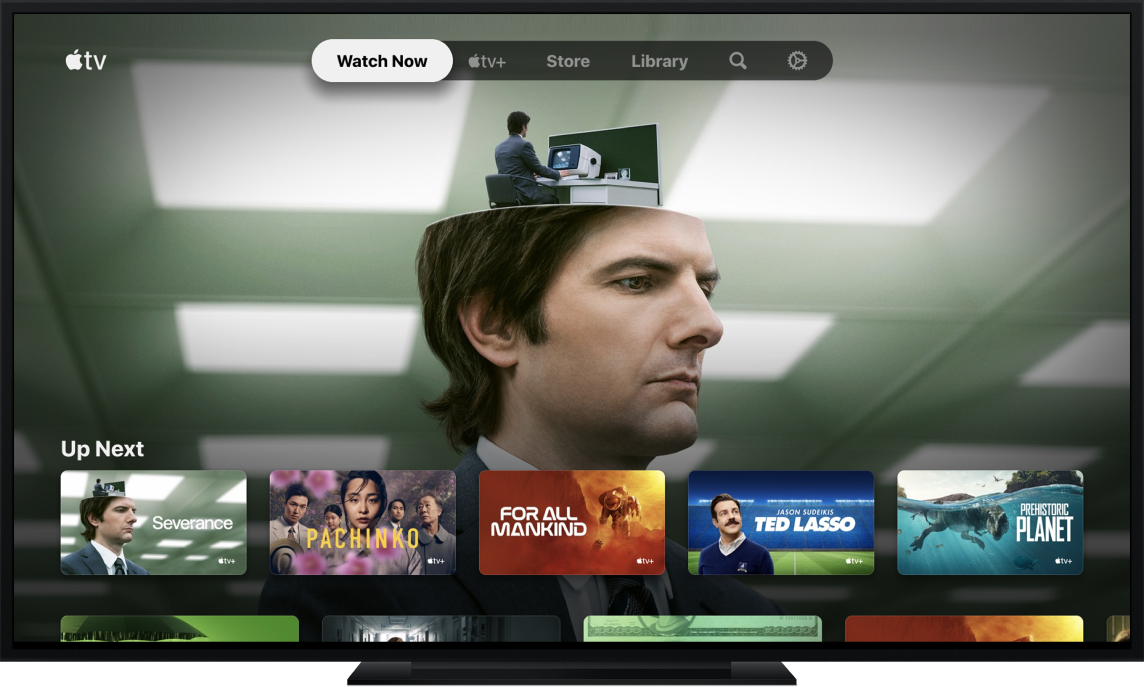

## Motivation

Apple TV+ is looking to increase their market share in the streaming marketplace. One way they think they can attract more subscribers is by increasing the amount of movies they offer on their platform. Apple TV+ would like to explore the use of recommendation engines when selecting movies to include on their platform with the end goal being to attract more subscribers. Using various Python packages, the final machine learning model has a RMSE of 0.83, meaning that it is able to predict the rating (out of 5) within 0.83 points of a given movie and user. 

## Overview

At first glance, recommendation systems have a very simple goal: **expose people to items that they will like**. However, there is much more that goes into a recommendation system behind the scenes.

From a data science definition, a recommendation system predicts the future preference of a set of items for a user, and recommends the top items from this set. In today's world, due to the internet and its global reach, people have more options to choose from than ever before.

Here's a formal definition of recommendation systems from authors [Bo Xiao and Izak Benbasat, 2017](https://misq.umn.edu/e-commerce-product-recommendation-agents-use-characteristics-and-impact.html):

> "Recommendation Systems are software agents that elicit the interests and preferences of individual consumers […] and make recommendations accordingly. They have the potential to support and improve the quality of the decisions consumers make while searching for and selecting products online."

## Recommendation System Approaches

At the top, there are two basic types of recommendation systems: **non-personalized** and **personalized**. This project will focus on personalized recommendation systems because that's where data scientists can provide the most value to companies, but to start off, we will summarize unpersonalized systems because they can be productive in their own right.

### Type #1: Non-Personalized Recommendations

Non-personalized recommendation systems have been happening since way before machine learning was ever in the public knowledge base. An example of an unpersonalized recommendation would be on YouTube when it recommends the most viewed videos. These are videos that the most people have watched. For the most part, these recommendations aren't too bad. After all, there's a reason why things are popular. This approach, however, is not going to help more niche videos get exposure. It also won't be immensely beneficial to those who have very particular tastes. Of course, there are times when a simple approach like this might be best. An example of a simple popularity recommender working well is with the news. There's a high chance that everyone who visits a news website is going to want to see whatever is the most popular at that moment in time.

### Type #2: Personalized Recommendations

According to Todd Yellin, Netflix’s vice president of product innovation:

> “Personalization is about creating the right connection between a viewer and their content.”
> [SOURCE](https://www.altexsoft.com/blog/recommender-system-personalization/)

In other words, personalization is the way to match the right types of services, products, or content to the right users. When approached appropriately, it helps improve user engagement — any interactions people have with a product, website, app, etc.

These days, the true power of customer experience personalization can be realized with the help of machine learning. By utilizing ML algorithms and data, it is possible to create smart models that can precisely predict customer intent and as such provide quality one-to-one recommendations.

At the same time, the continuous growth of available data has led to information overload — when too many choices complicate decision-making. Primarily developed to help users deal with the large range of choices they encounter, recommender systems come into play.

Recommender systems, also known as recommender engines, are information filtering systems that provide individual recommendations in real-time. As powerful personalization tools, recommendation systems leverage machine learning algorithms and techniques to give the most relevant suggestions to particular users by learning data (e.g., past behaviors) and predicting current interests and preferences.

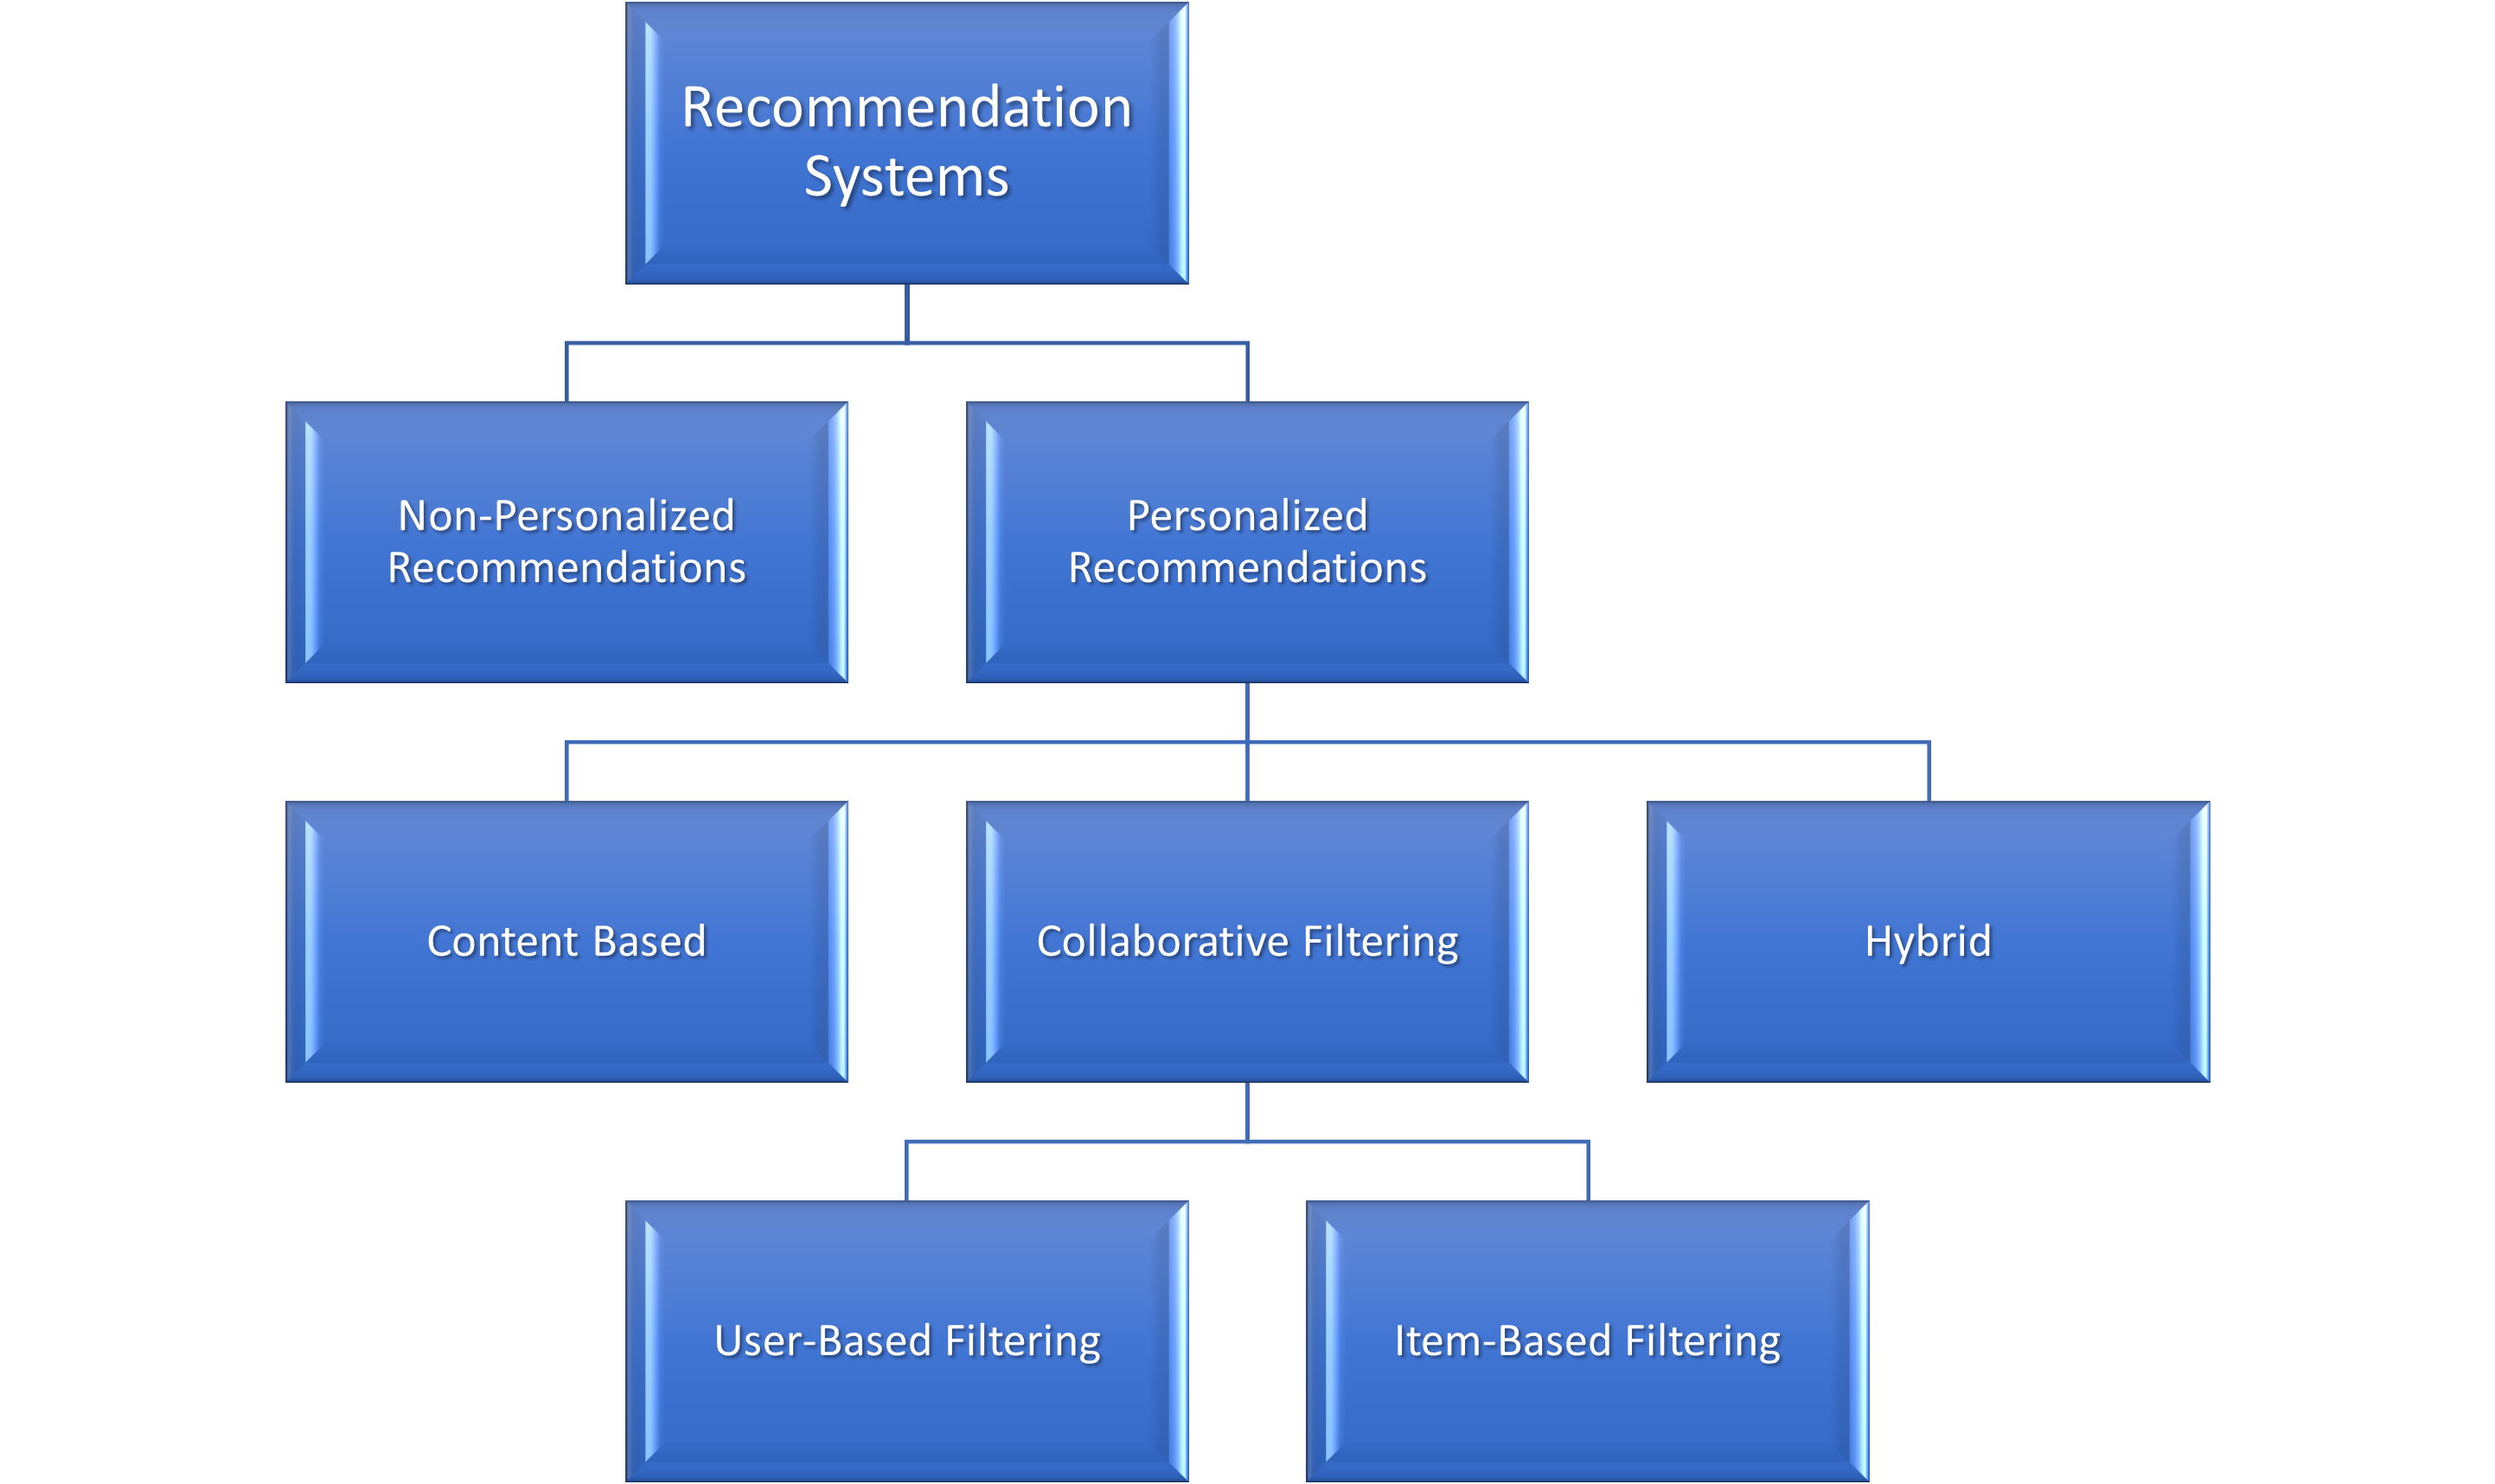

## Approaches

This project is going to use all 3 main approaches to personalized recommendations to predict what movie a user would prefer:

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

Now that we have a general overview of what a recommendation system is and how it works, let's dive in to our data.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import squarify
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from surprise import Reader, Dataset, KNNBasic, KNNBaseline, SVD, KNNWithMeans, accuracy, NormalPredictor, KNNWithZScore
from surprise import BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.accuracy import rmse
from surprise.model_selection import train_test_split as train_test_split_surprise
import string
import re
%matplotlib inline

## Load the Data

This project used 3 datasets, some of which have multiple files within them:

1. [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots)
  * `wiki_movie_plots_deduped`
2. [IMDB](https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset)
  * `ratings_data`
  * `basic_name_data`
  * `title_basics_data`
  * `title_principals_data`
3. [MovieLens 100K](https://grouplens.org/datasets/movielens/latest/)
  * `links`
  * `movies`
  * `ratings`

## Wikipedia Data

There is 1 file within the Wikipedia Data set: `wiki_movie_plots_deduped`.

In [2]:
# Load the data
plots_df = pd.read_csv('Data/Wikipedia Movie Plots/wiki_movie_plots_deduped.csv')

# Preview the data
plots_df.head()

Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.org/wiki/Terrible_Teddy,_...   
4  https://en.wikipedia.org/wiki/Jack_and_the_Bea...   

                                                Plot  
0  A bartender is working at a saloon, serving dr...  
1  The moon, painted with a smiling face hangs ov...  
2  The film, just over a minute long, is composed...  
3  Lasting just 61 seconds and consisting of two ...  
4  The earliest known adaptation of the classic f...

The first type of model we are going to build will use **content-based collaborative filtering**, specifically on the `Plot` column. Before doing that, let's take a closer look at our data.

# Preliminary Exploratory Data Analysis

In [3]:
# Check for missing values
plots_df.isna().sum()

Release Year           0
Title                  0
Origin/Ethnicity       0
Director               0
Cast                1422
Genre                  0
Wiki Page              0
Plot                   0
dtype: int64

In [4]:
# Value counts of `Genre`
plots_df['Genre'].value_counts()

unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre, Length: 2265, dtype: int64

Even though we only have missing values in the `Cast` column, we can see above that we are missing plenty of information in the `Genre` column as well because it includes the entry `unknown`. Let's take a look at our dataframe in a bit further detail.

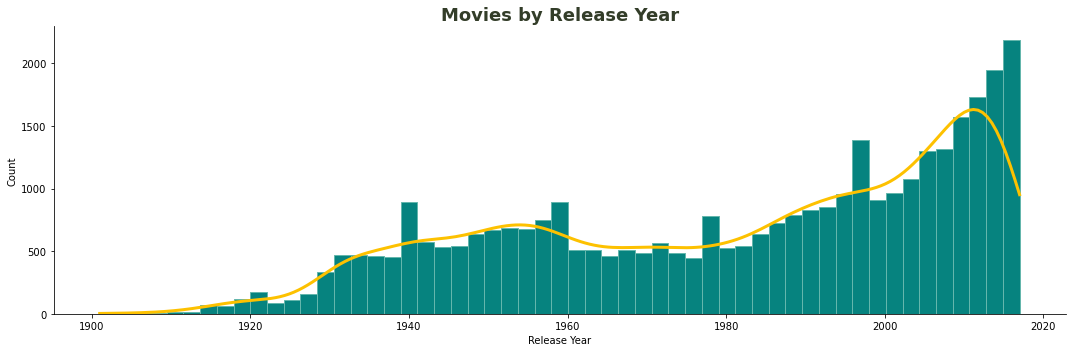

In [5]:
# Create displot
sns.displot(data=plots_df, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

# Label our headings
plt.title('Movies by Release Year', fontsize=18, weight=600, color='#333d29')

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Movies by Release Year.png');

It looks like our movies by release year is skewed left. Or in other words, we have more movies released in the current era, which does make sense when you think about it logically.

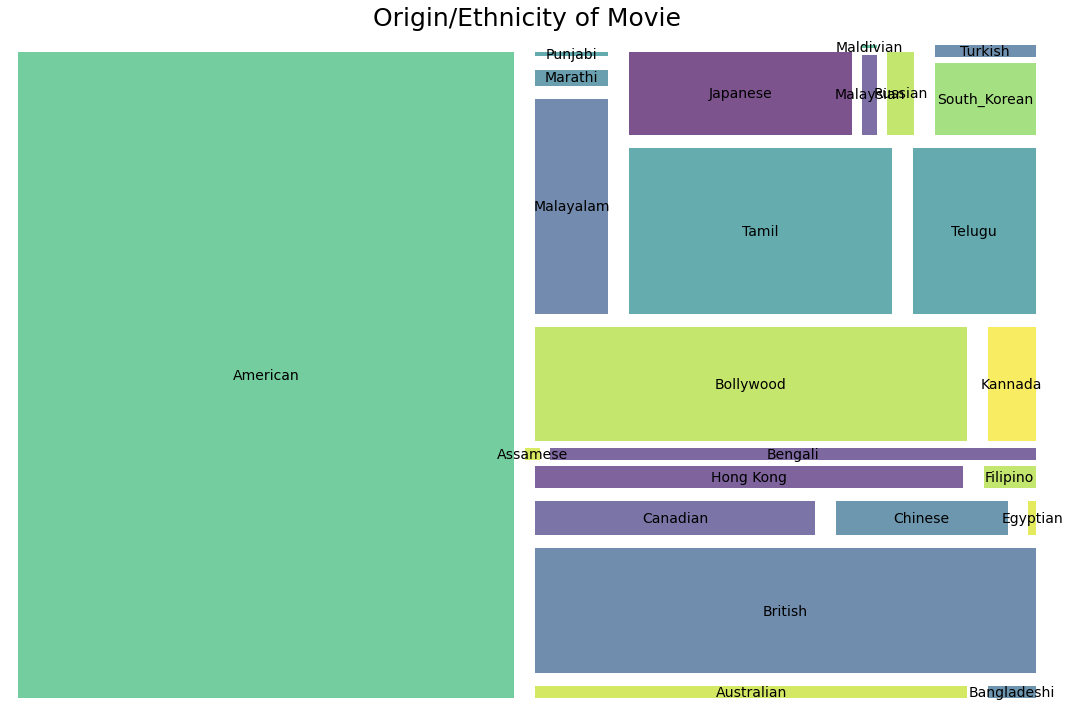

In [6]:
# Count origin column
origin_info = Counter(plots_df['Origin/Ethnicity'])

# Create plot
plt.figure(figsize=(15, 10))
plt.title("Origin/Ethnicity of Movie", fontsize=25, pad=20)
squarify.plot(origin_info.values(), label=origin_info.keys(), text_kwargs={'fontsize':14}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off")

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Movie Ethnicity.png');

We can see that the vast majority of our movies are American. 

Now that we have a decent understanding of our first dataframe, let's move onto our first model.

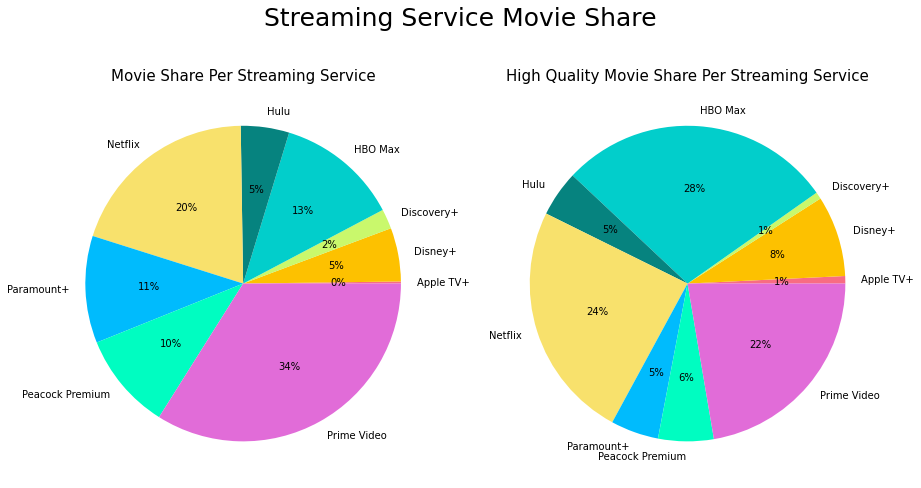

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,7.5))

# Define data
total_movies = [44, 1129, 417, 2586, 1019, 4091, 2257, 2051, 6985]
high_quality_movies = [14, 152, 13, 517, 86, 447, 90, 104, 409]
labels = ['Apple TV+', 'Disney+', 'Discovery+', 'HBO Max', 'Hulu', 'Netflix', 
          'Paramount+', 'Peacock Premium', 'Prime Video']

colors= ['#f86c83', '#fdc100', '#c9f86c', '#02cecb', '#06837f', '#f8e16c', '#00bbfd', '#00fdc1', '#e16cd8']

# Create pie chart
fig.suptitle("Streaming Service Movie Share", fontsize=25)

ax1.pie(total_movies, labels = labels, colors = colors, autopct='%.0f%%')
ax1.set_title("Movie Share Per Streaming Service", fontsize=15)

ax2.pie(high_quality_movies, labels = labels, colors = colors, autopct='%.0f%%')
ax2.set_title("High Quality Movie Share Per Streaming Service", fontsize=15)

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Streaming Service Movie Share.png')

plt.show();

# Modeling

Let's recall our graph and goals for this project. 

* **Content-based filtering**, which generates predictions by analyzing item attributes and searching for similarities between them
* **Memory-based Collaborative filtering**, which generates predictions by analyzing user behavior and matching users with similar tastes
* **Hybrid filtering**, which combines two or more models.

# Content-based Filtering

The first recommender system we are going to create is **content-based**. For this model, we will first generate recommendations of movies based on a watched movie's plot. From there, we will recommend movies based on the genre of a watched movie.

<div>
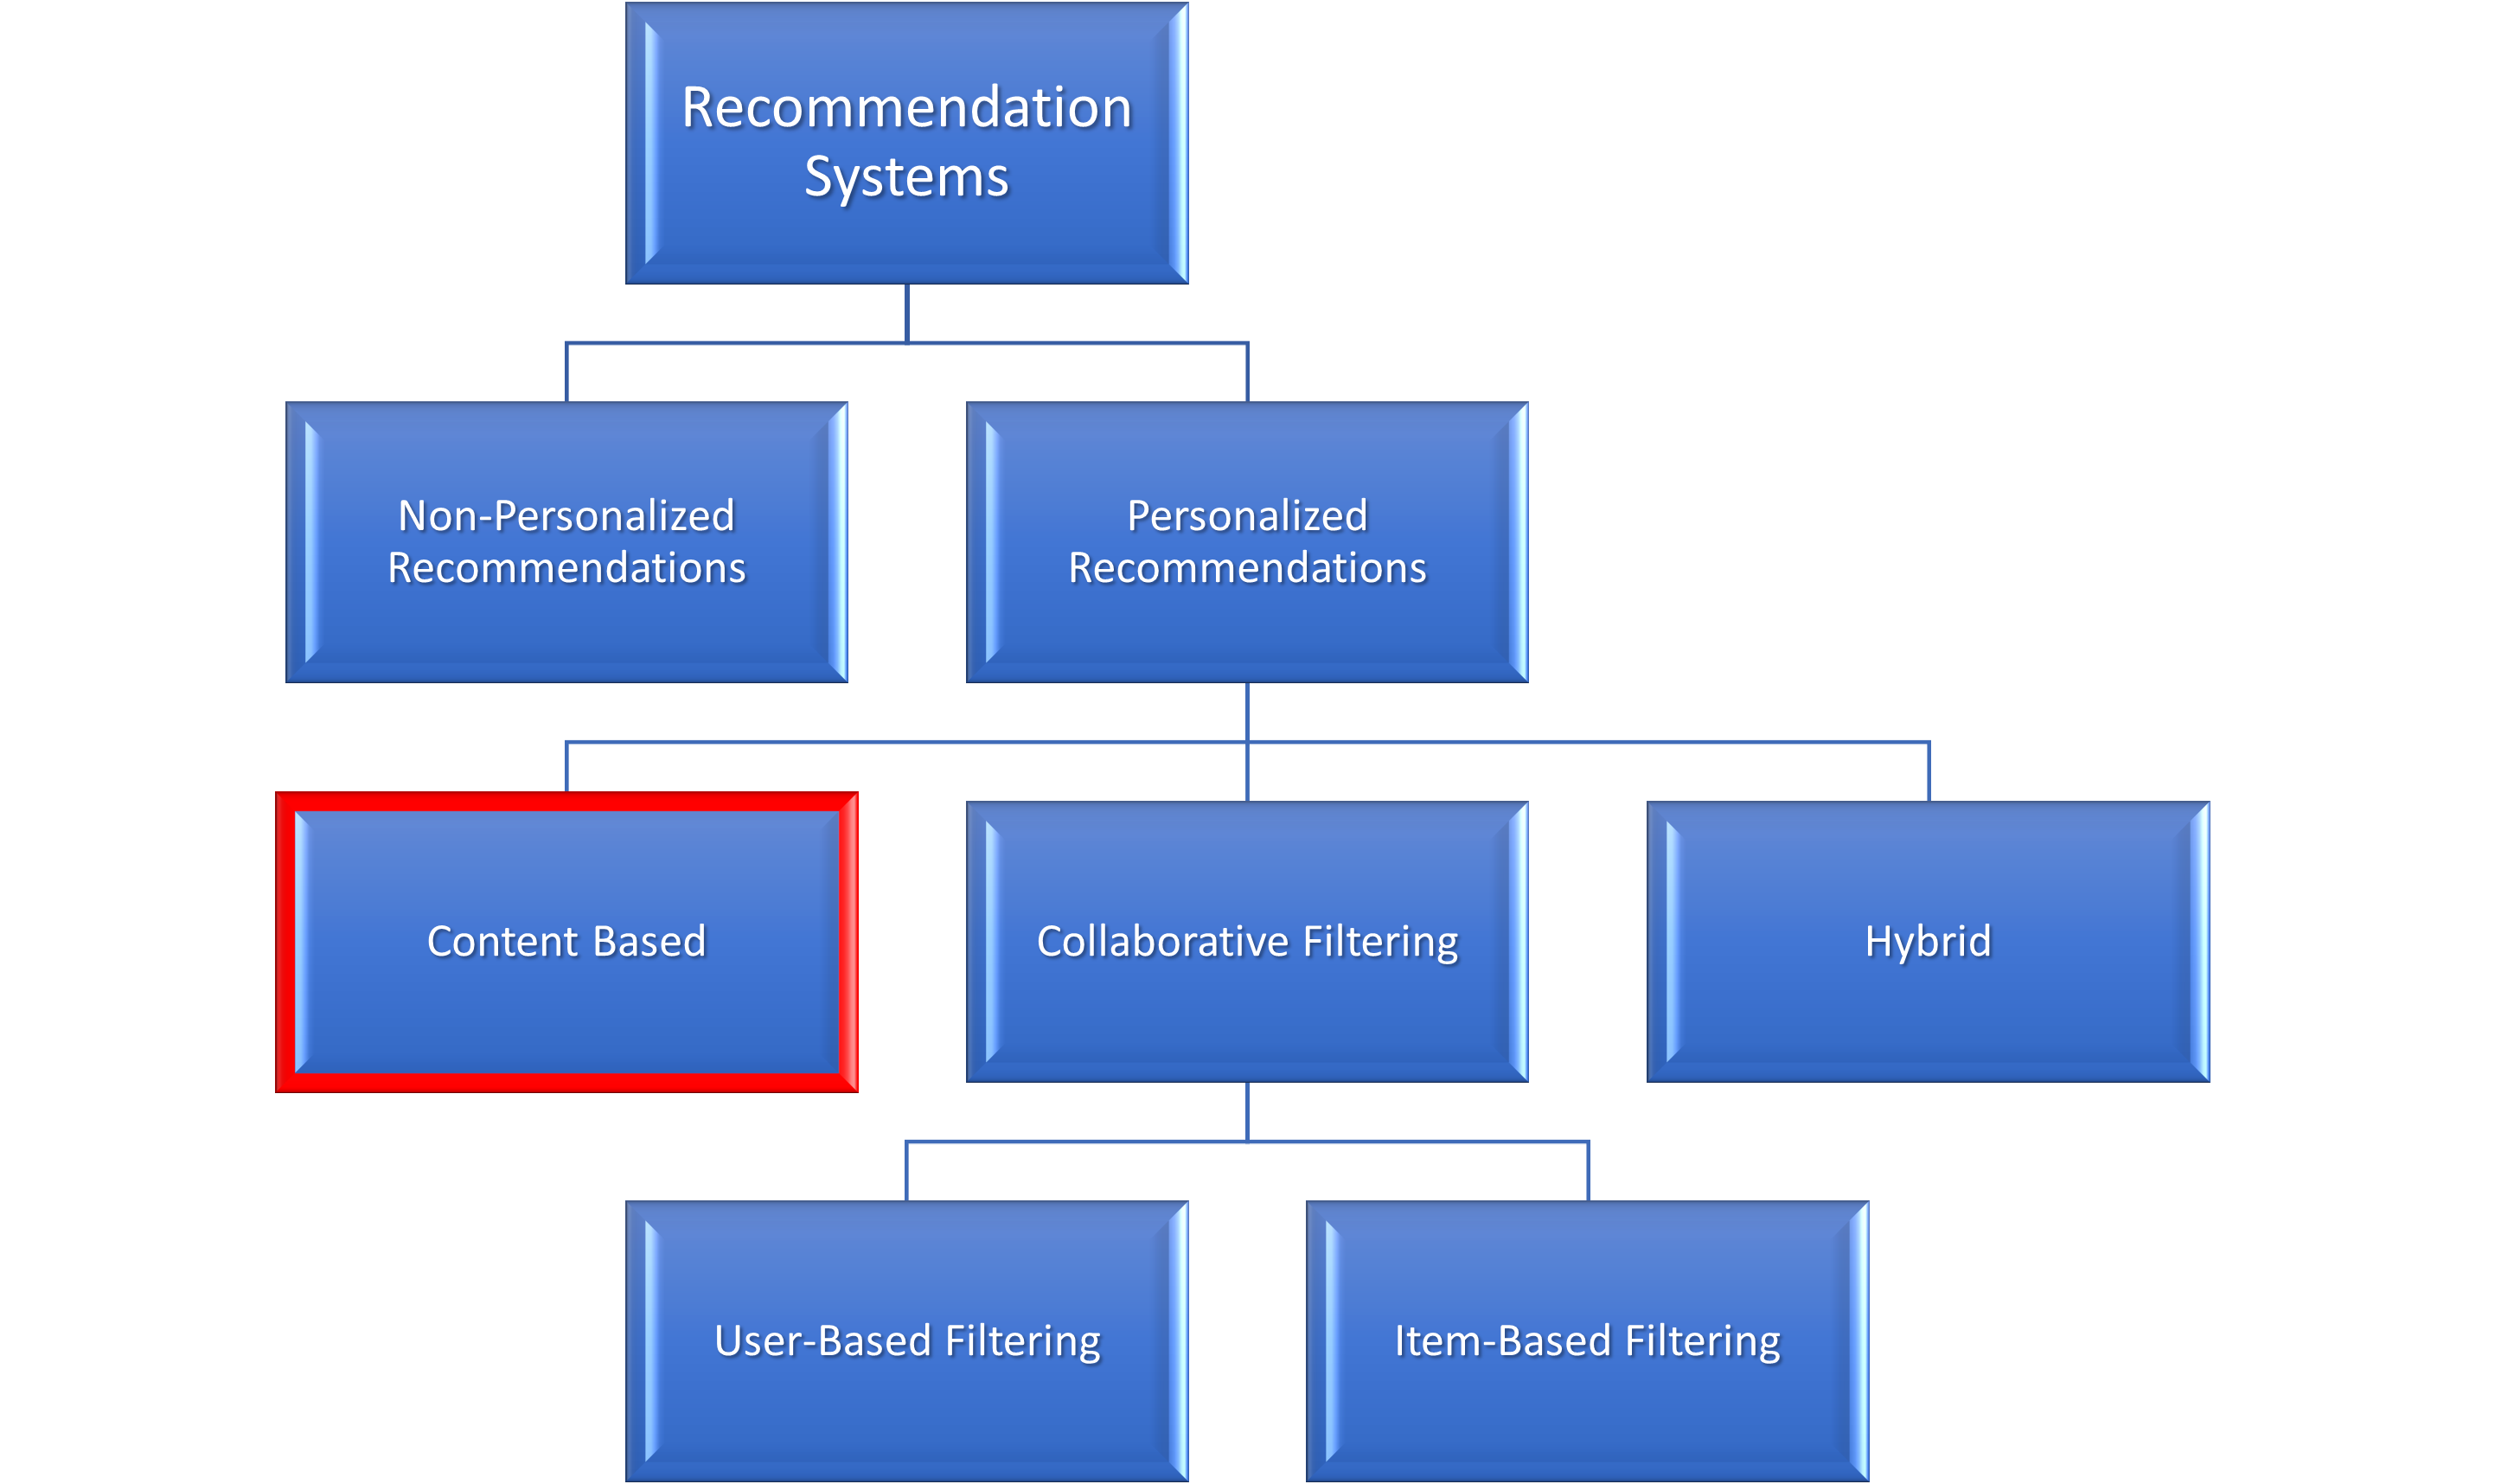
</div>

## TF-IDFVectorizer

Not all words in a document carry equal weight. We know this from looking at stopwords. But the words that were in the vocabulary were all given equal weighting.

Should this always be the case...?

For example, consider a corpus of documents on dogs. Now, it is obvious that all these documents will frequently contain the word dog. Therefore, the appearance of the word dog isn't as important as another word that only appears in a few documents.

**TF-IDFVectorizer (Term Frequency-Inverse Document Frequency)** takes the aforementioned point into consideration and assigns weights to each word according to the following formula.

$$\large IDF(t) = log_e(\frac{Total\ Number\ of\ Documents}{Number\ of\ Documents\ with\ t\ in\ it})$$

[SCIKIT LEARN DOCUMENTATION](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Just keep in mind that the weight of a word in a document is greater if it occurs more frequently in that document and is present in fewer documents. The weight takes values between 0 and 1.

We will be using TF-IDFVectorizer because some words occur much more frequently in plot descriptions than others. It is therefore a good idea to assign weights to each word in a document according to the TF-IDF formula. Another reason to use TF-IDF is that it speeds up the calculation of the cosine similarity score between a pair of documents. 

We will mainly use the `Plot` information from our `non_dup_movies` dataframe. First, we will clean up the `Plot` column by lowering the case of all of the words and removing the punctuation. From there we will fit and transform the `Clean_Plot` column using a `TfidfVectorizer`. 

## Cosine Similarity Score

The cosine score is extremely robust and easy to calculate (especially when used in conjunction with TF-IDFVectorizer).

The cosine similarity score between two documents, x and y, is as follows:

$$\large cosine(x,y) = \frac{X \cdot y^T}{\parallel x \parallel \cdot \parallel y \parallel}$$

The cosine score can take any value between -1 and 1. The higher the cosine score, the more similar the documents are to each other. We now have a good theoretical base to proceed to build the content-based recommenders using Python.

## Plot description-based recommender

Our plot description-based recommender will take in a movie title as an argument and output a list of movies that are most similar based on their plots. These are the steps we are going to perform in building this model:

1. Obtain the data required to build the model
2. Create TF-IDF vectors for the plot description (or overview) of every movie
3. Compute the pairwise cosine similarity score of every movie
4. Write the recommender function that takes in a movie title as an argument and outputs movies most similar to it based on the plot

In [8]:
# Display our dataframe
plots_df.head()

Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast    Genre  \
0                             Unknown  NaN  unknown   
1                             Unknown  NaN  unknown   
2                             Unknown  NaN  unknown   
3                             Unknown  NaN  unknown   
4  George S. Fleming, Edwin S. Porter  NaN  unknown   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://en.wikipedia.org/wiki/Terrible_Teddy,_...   
4  https://en.wikipedia.org/wiki/Jack_and_the_Bea...   

                                                Plot  
0  A bartender is working at a saloon, serving dr...  
1  The moon, painted with a smiling face hangs ov...  
2  The film, just over a minute long, is composed...  
3  Lasting just 61 seconds and consisting of two ...  
4  The earliest known adaptation of the classic f...

In [9]:
# Standardize the case for our `Plot`
plots_df['Clean_Plot'] = plots_df['Plot'].str.lower()

# Remove punctuation
plots_df['Clean_Plot'] = plots_df['Clean_Plot'].str.translate(str.maketrans('', '', string.punctuation))

In [10]:
# Instantiate a vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on plots_df['Clean_Plot'] and transform it
movies_vectorized = tfidf.fit_transform(plots_df['Clean_Plot'])

# Preview the shape
movies_vectorized.shape

(34886, 178166)

We can see that the vectorizer has created a 178,166-dimensional vector for the overview of every movie.

### Compute the Cosine Similarity Score

The next step is to calculate the pairwise cosine similarity score of every movie. In other words, we are going to create a 34,886 × 34,886 matrix, where the cell in the ith row and jth column represents the similarity score between movies i and j. We can easily see that this matrix is symmetric in nature and every element in the diagonal is 1, since it is the similarity score of the movie with itself.

Like `TF-IDFVectorizer`, scikit-learn also has functionality for computing the aforementioned similarity matrix. Calculating the cosine similarity is, however, a computationally expensive process. Fortunately, since our movie plots are represented as TF-IDF vectors, their magnitude is always 1. Hence, we do not need to calculate the denominator in the cosine similarity formula as it will always be 1. Our work is now reduced to computing the much simpler and computationally cheaper dot product (a functionality that is also provided by scikit-learn).

In [11]:
# Apply `linear_kernel` to our vector
cosine_sim = linear_kernel(movies_vectorized, movies_vectorized)

# Preview the results
cosine_sim

array([[1.        , 0.03026373, 0.00777599, ..., 0.        , 0.00371386,
        0.        ],
       [0.03026373, 1.        , 0.00892876, ..., 0.        , 0.01005604,
        0.0191672 ],
       [0.00777599, 0.00892876, 1.        , ..., 0.00766691, 0.00622522,
        0.        ],
       ...,
       [0.        , 0.        , 0.00766691, ..., 1.        , 0.0115371 ,
        0.00613037],
       [0.00371386, 0.01005604, 0.00622522, ..., 0.0115371 , 1.        ,
        0.00300791],
       [0.        , 0.0191672 , 0.        , ..., 0.00613037, 0.00300791,
        1.        ]])

With the similarity scores of every movie with every other movie, we are now in a very good position to write our final recommender function.

### Building the recommender function

The final step is to create our recommender function. However, before we do that, let's create a reverse mapping of movie titles and their respective indices. In other words, let's create a pandas series with the index as the movie title and the value as the corresponding index in the main DataFrame:

In [12]:
# Create variable `indices` to pull the index of each movie
indices = pd.Series(plots_df.index, index=plots_df['Title']).drop_duplicates()

# Preview the results
indices

Title
Kansas Saloon Smashers                  0
Love by the Light of the Moon           1
The Martyred Presidents                 2
Terrible Teddy, the Grizzly King        3
Jack and the Beanstalk                  4
                                    ...  
The Water Diviner                   34881
Çalgı Çengi İkimiz                  34882
Olanlar Oldu                        34883
Non-Transferable                    34884
İstanbul Kırmızısı                  34885
Length: 34886, dtype: int64

We will perform the following steps in building the recommender function:

1. Declare the title of the movie as an argument.
2. Obtain the index of the movie from the indices reverse mapping.
3. Get the list of cosine similarity scores for that particular movie with all movies using cosine_sim. Convert this into a list of tuples where the first element is the position and the second is the similarity score.
4. Sort this list of tuples on the basis of the cosine similarity scores.
5. Get the top 10 elements of this list. Ignore the first element as it refers to the similarity score with itself (the movie most similar to a particular movie is obviously the movie itself).
6. Return the titles corresponding to the indices of the top 10 elements, excluding the first:

In [13]:
def get_recommendations(title, cosine_sim, df, indices):
    
    # Obtain the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwsie similarity scores of all movies with that movie
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies, ignore the first movie
    sim_scores = sim_scores[1:11]
    
    # Find the movies that match with those indicies
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return pd.DataFrame(df['Title'].iloc[movie_indices])

Let's try it out!

In [14]:
get_recommendations('Toy Story', cosine_sim, plots_df, indices)

Title
13574            Toy Story 2
5342    Destination Meatball
15948            Toy Story 3
5203            Puny Express
16619               Nebraska
16606                    LUV
3731   The Barber of Seville
2811        Girl from Havana
6608           Mr. B Natural
22145  It's a Boy Girl Thing

We see that our recommender has suggested all of Toy Story's sequels in its top-10 list. 

It goes without saying that a person who loves Toy Story is very likely to have a thing for Disney movies. They may also prefer to watch animated movies. Unfortunately, our plot description recommender isn't able to capture all this information.

Therefore next we will build a recommender that uses more advanced metadata, such as genres, cast, and directors. This recommender will be able to do a much better job of identifying an individual's taste for a particular director, actor, sub-genre, and so on.

# Metadata-based Recommender

While this is still a content-based recommendation engine, we are going to use the following metdata:

* The genre of the movie
* The director of the movie
* Major stars and cast

## IMDB Dataset

Now we are going to load in information from our second dataset, The IMDB Data set. There are 4 files located within this dataset:

  * `ratings_data`
  * `basic_name_data`
  * `title_basics_data`
  * `title_principals_data` 
  
### Load The Data

In [15]:
# Load the data
imdb_ratings_df = pd.read_csv('Data/IMDB/ratings_data.tsv', sep='\t')

# Preview the data
imdb_ratings_df.head()

tconst  averageRating  numVotes
0  tt0000001            5.7      1923
1  tt0000002            5.8       259
2  tt0000003            6.5      1737
3  tt0000004            5.6       174
4  tt0000005            6.2      2550

In [16]:
# Load the data
name_df = pd.read_csv('Data/IMDB/basic_name_data.tsv', sep='\t')

# Preview the data
name_df.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire      1899      1987   
1  nm0000002    Lauren Bacall      1924      2014   
2  nm0000003  Brigitte Bardot      1934        \N   
3  nm0000004     John Belushi      1949      1982   
4  nm0000005   Ingmar Bergman      1918      2007   

                     primaryProfession  \
0       soundtrack,actor,miscellaneous   
1                   actress,soundtrack   
2  actress,soundtrack,music_department   
3              actor,soundtrack,writer   
4                writer,director,actor   

                            knownForTitles  
0  tt0072308,tt0053137,tt0050419,tt0031983  
1  tt0117057,tt0038355,tt0037382,tt0071877  
2  tt0056404,tt0057345,tt0049189,tt0054452  
3  tt0078723,tt0080455,tt0072562,tt0077975  
4  tt0050976,tt0083922,tt0060827,tt0050986

In [17]:
# Load the data
title_basics_df = pd.read_csv('Data/IMDB/title_basics_data.tsv', sep='\t', low_memory=False)

# Preview the data
title_basics_df.head()

tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short

In [18]:
# Load the data
title_principals_df = pd.read_csv('Data/IMDB/title_principals_data.tsv', sep='\t')

# Preview the data
title_principals_df

tconst  ordering      nconst         category  \
0         tt0000001         1   nm1588970             self   
1         tt0000001         2   nm0005690         director   
2         tt0000001         3   nm0374658  cinematographer   
3         tt0000002         1   nm0721526         director   
4         tt0000002         2   nm1335271         composer   
...             ...       ...         ...              ...   
53173242  tt9916880         4  nm10535738          actress   
53173243  tt9916880         5   nm0996406         director   
53173244  tt9916880         6   nm1482639           writer   
53173245  tt9916880         7   nm2586970           writer   
53173246  tt9916880         8   nm1594058         producer   

                              job        characters  
0                              \N          ["Self"]  
1                              \N                \N  
2         director of photography                \N  
3                              \N                \N  
4                              \N                \N  
...                           ...               ...  
53173242                       \N  ["Horrid Henry"]  
53173243       principal director                \N  
53173244                       \N                \N  
53173245                    books                \N  
53173246                 producer                \N  

[53173247 rows x 6 columns]

Before merging this dataset with our `plots_df` we need to filter and merge the IMDB dataset and clean it up.

## Merge The Datasets

Now that we have all of our data loaded, we need to start organizing them into forms that will work for our recommendation engines and also merge them into one big dataframe.

Let's start with the `title_basics_df`.

In [19]:
print('Title Basics Dataframe Shape:', title_basics_df.shape, '\n')

# Preview types of titles
print(title_basics_df['titleType'].value_counts())

Title Basics Dataframe Shape: (9389356, 9) 

tvEpisode       7091360
short            901062
movie            627705
video            267519
tvSeries         234495
tvMovie          138357
tvMiniSeries      46065
tvSpecial         39207
videoGame         32838
tvShort           10746
tvPilot               2
Name: titleType, dtype: int64


As we can see above, `title_basics_df` includes amost 10 million rows with all types of media options:

* `tvEpisode`
* ` short`
* `movie`
* `video`
* `tvSeries`
* `tvMovie`
* `tvMiniSeries`
* `tvSpecial`
* `videoGame`
* `tvShort`
* `tvPilot`

We are only interested in the `movie` title type so let's filter down this dataframe to only include those options.

In [20]:
# Filter titles to only contain 'movies'
title_basics_df = title_basics_df.loc[title_basics_df['titleType'].str.contains('movie')]

# Preview the filtering
title_basics_df.head()

tconst titleType                 primaryTitle  \
8    tt0000009     movie                   Miss Jerry   
498  tt0000502     movie                     Bohemios   
570  tt0000574     movie  The Story of the Kelly Gang   
587  tt0000591     movie             The Prodigal Son   
610  tt0000615     movie           Robbery Under Arms   

                   originalTitle isAdult startYear endYear runtimeMinutes  \
8                     Miss Jerry       0      1894      \N             45   
498                     Bohemios       0      1905      \N            100   
570  The Story of the Kelly Gang       0      1906      \N             70   
587            L'enfant prodigue       0      1907      \N             90   
610           Robbery Under Arms       0      1907      \N             \N   

                         genres  
8                       Romance  
498                          \N  
570  Action,Adventure,Biography  
587                       Drama  
610                       Drama

In [21]:
# Check if it worked
title_basics_df['titleType'].value_counts()

movie    627705
Name: titleType, dtype: int64

Now that we only have the titleType of `movies` let's start pairing this dataframe down to only the information we need and work on merging it with the other dataset from IMDB. Luckily, it looks like we have a matching column in both dataframes titled `tconst`.

In [22]:
# Merge the datasets on `tconst`
imdb_df = pd.merge(title_basics_df, imdb_ratings_df, on='tconst')

# Preview new dataframe
imdb_df.head()

tconst titleType                 primaryTitle  \
0  tt0000009     movie                   Miss Jerry   
1  tt0000502     movie                     Bohemios   
2  tt0000574     movie  The Story of the Kelly Gang   
3  tt0000591     movie             The Prodigal Son   
4  tt0000615     movie           Robbery Under Arms   

                 originalTitle isAdult startYear endYear runtimeMinutes  \
0                   Miss Jerry       0      1894      \N             45   
1                     Bohemios       0      1905      \N            100   
2  The Story of the Kelly Gang       0      1906      \N             70   
3            L'enfant prodigue       0      1907      \N             90   
4           Robbery Under Arms       0      1907      \N             \N   

                       genres  averageRating  numVotes  
0                     Romance            5.3       200  
1                          \N            4.2        14  
2  Action,Adventure,Biography            6.0       796  
3                       Drama            5.1        20  
4                       Drama            4.3        23

In [23]:
imdb_df.drop(columns=['titleType', 'originalTitle', 'isAdult'], axis=1, inplace=True)

In [24]:
# Checking for missing values
imdb_df.isna().sum()

tconst            0
primaryTitle      0
startYear         0
endYear           0
runtimeMinutes    0
genres            0
averageRating     0
numVotes          0
dtype: int64

Great. Now that we have that dataframe paired down, we are going to try to do the same with the `title_principals_df`.

In [25]:
print('Title Principals Dataframe Shape:', title_principals_df.shape, '\n')

# Preview types of titles
print(title_principals_df['category'].value_counts())

Title Principals Dataframe Shape: (53173247, 6) 

actor                  11746301
self                    9236787
actress                 9068782
writer                  7415603
director                6137518
producer                3440477
cinematographer         1838693
composer                1811735
editor                  1776215
production_designer      352295
archive_footage          345094
archive_sound              3747
Name: category, dtype: int64


Wow, this dataframe is over 53 million rows long! Luckily we only need one of the columns: `director`.

In [26]:
# Filter titles to only contain 'movies'
title_principals_df = title_principals_df.loc[title_principals_df['category'].str.contains('director')]

# Preview the filtering
print('Shape of dataframe', title_principals_df.shape)
title_principals_df.head()

Shape of dataframe (6137518, 6)


tconst  ordering     nconst  category job characters
1   tt0000001         2  nm0005690  director  \N         \N
3   tt0000002         1  nm0721526  director  \N         \N
5   tt0000003         1  nm0721526  director  \N         \N
9   tt0000004         1  nm0721526  director  \N         \N
13  tt0000005         3  nm0005690  director  \N         \N

We can see that we have now paired this down to just over 6 million directors. Let's pull out the columns we need and merge this with our `name_df` to get each director's name.

In [27]:
# Drop unnecessary columns
directors_df = title_principals_df[['tconst', 'nconst']]

# Preview data
directors_df.head()

tconst     nconst
1   tt0000001  nm0005690
3   tt0000002  nm0721526
5   tt0000003  nm0721526
9   tt0000004  nm0721526
13  tt0000005  nm0005690

In [28]:
# Drop unnecessary columns
name_df.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Preview data
name_df.head()

nconst      primaryName                    primaryProfession  \
0  nm0000001     Fred Astaire       soundtrack,actor,miscellaneous   
1  nm0000002    Lauren Bacall                   actress,soundtrack   
2  nm0000003  Brigitte Bardot  actress,soundtrack,music_department   
3  nm0000004     John Belushi              actor,soundtrack,writer   
4  nm0000005   Ingmar Bergman                writer,director,actor   

                            knownForTitles  
0  tt0072308,tt0053137,tt0050419,tt0031983  
1  tt0117057,tt0038355,tt0037382,tt0071877  
2  tt0056404,tt0057345,tt0049189,tt0054452  
3  tt0078723,tt0080455,tt0072562,tt0077975  
4  tt0050976,tt0083922,tt0060827,tt0050986

In [29]:
# Merge dataframes
dir_name_df = pd.merge(name_df, directors_df, on='nconst').drop_duplicates()

# Preview results
dir_name_df.head()

nconst     primaryName      primaryProfession  \
0  nm0000005  Ingmar Bergman  writer,director,actor   
1  nm0000005  Ingmar Bergman  writer,director,actor   
2  nm0000005  Ingmar Bergman  writer,director,actor   
3  nm0000005  Ingmar Bergman  writer,director,actor   
4  nm0000005  Ingmar Bergman  writer,director,actor   

                            knownForTitles     tconst  
0  tt0050976,tt0083922,tt0060827,tt0050986  tt0038468  
1  tt0050976,tt0083922,tt0060827,tt0050986  tt0038675  
2  tt0050976,tt0083922,tt0060827,tt0050986  tt0039834  
3  tt0050976,tt0083922,tt0060827,tt0050986  tt0040418  
4  tt0050976,tt0083922,tt0060827,tt0050986  tt0040622

Now that we have the name of each director, we can merge this dataframe with our `imdb_df` to align each director with the film they worked on.

In [30]:
# Merge dataframes
imdb_df = pd.merge(imdb_df, dir_name_df, on='tconst')

# Preview results
imdb_df.head()

tconst                 primaryTitle startYear endYear runtimeMinutes  \
0  tt0000009                   Miss Jerry      1894      \N             45   
1  tt0000502                     Bohemios      1905      \N            100   
2  tt0000574  The Story of the Kelly Gang      1906      \N             70   
3  tt0000591             The Prodigal Son      1907      \N             90   
4  tt0000615           Robbery Under Arms      1907      \N             \N   

                       genres  averageRating  numVotes     nconst  \
0                     Romance            5.3       200  nm0085156   
1                          \N            4.2        14  nm0063413   
2  Action,Adventure,Biography            6.0       796  nm0846879   
3                       Drama            5.1        20  nm0141150   
4                       Drama            4.3        23  nm0533958   

        primaryName                primaryProfession  \
0   Alexander Black  director,writer,cinematographer   
1  Ricardo de Baños  director,cinematographer,writer   
2      Charles Tait                  director,writer   
3      Michel Carré            director,writer,actor   
4  Charles MacMahon         director,writer,producer   

                            knownForTitles  
0                                tt0000009  
1  tt0000941,tt0002886,tt0004406,tt0024495  
2                                tt0000574  
3  tt0433554,tt0433594,tt0431913,tt0000591  
4                      tt0203505,tt0000615

In [31]:
# Drop unnecessary columns
imdb_df.drop(columns=['endYear', 'primaryProfession', 'nconst'], axis=1, inplace=True)

# Preview results
imdb_df.head()

tconst                 primaryTitle startYear runtimeMinutes  \
0  tt0000009                   Miss Jerry      1894             45   
1  tt0000502                     Bohemios      1905            100   
2  tt0000574  The Story of the Kelly Gang      1906             70   
3  tt0000591             The Prodigal Son      1907             90   
4  tt0000615           Robbery Under Arms      1907             \N   

                       genres  averageRating  numVotes       primaryName  \
0                     Romance            5.3       200   Alexander Black   
1                          \N            4.2        14  Ricardo de Baños   
2  Action,Adventure,Biography            6.0       796      Charles Tait   
3                       Drama            5.1        20      Michel Carré   
4                       Drama            4.3        23  Charles MacMahon   

                            knownForTitles  
0                                tt0000009  
1  tt0000941,tt0002886,tt0004406,tt0024495  
2                                tt0000574  
3  tt0433554,tt0433594,tt0431913,tt0000591  
4                      tt0203505,tt0000615

Now that we have all of the data out of the `imdb_df`, we can now merge it with our existing Wikipedia dataframe. Let's take a look at the shape of each dataframe to see how big they are before we go any further.

In [32]:
# View length of each dataframe
print('IMDB Length of Films:', imdb_df.shape[0])
print('Wikipedia Length of Films:', plots_df.shape[0])

IMDB Length of Films: 294213
Wikipedia Length of Films: 34886


Unfortunately these two dataframes do not have a column to merge them exactly, but we can merge them on the title and release year. Let's put them together to see how long our new dataframe will be.

In [33]:
# Change `Release Year` to an string
plots_df['Release Year'] = plots_df['Release Year'].astype('str')

In [34]:
# Merge two dataframes
imdb_wiki = pd.merge(plots_df, imdb_df, left_on=['Title', 'Release Year'], right_on=['primaryTitle', 'startYear'])

In [35]:
# Drop duplicates
imdb_wiki.drop_duplicates(inplace=True)

In [36]:
# Check for missing values
imdb_wiki.isna().sum()

Release Year          0
Title                 0
Origin/Ethnicity      0
Director              0
Cast                688
Genre                 0
Wiki Page             0
Plot                  0
Clean_Plot            0
tconst                0
primaryTitle          0
startYear             0
runtimeMinutes        0
genres                0
averageRating         0
numVotes              0
primaryName           0
knownForTitles        0
dtype: int64

In [37]:
# Drop unnecessary columns
imdb_wiki.drop(columns=['Origin/Ethnicity', 'Director', 'Wiki Page', 'primaryTitle', 
                                'startYear', 'Genre', 'knownForTitles'], 
                                axis=1, inplace=True)

# Preview results
imdb_wiki.head()

Release Year                    Title  \
0         1913                 Atlantis   
1         1914  The Battle of the Sexes   
2         1914      Brewster's Millions   
3         1914      Brewster's Millions   
4         1914    The Call of the North   

                                            Cast  \
0                                            NaN   
1                      Donald Crisp, Lilian Gish   
2  Edward Abeles, Sydney Deane, Joseph Singleton   
3  Edward Abeles, Sydney Deane, Joseph Singleton   
4                Robert Edeson, Theodore Roberts   

                                                Plot  \
0  Dr. Friedrich von Kammacher (Olaf Fønss), a su...   
1  Frank Andrews (Donald Crisp) is a well-to-do, ...   
2  Wealthy Edwin Peter Brewster disowns his son R...   
3  Wealthy Edwin Peter Brewster disowns his son R...   
4  Graehme, Ned Stewart's father was accused of a...   

                                          Clean_Plot     tconst  \
0  dr friedrich von kammacher olaf fønss a surgeo...  tt0002646   
1  frank andrews donald crisp is a welltodo middl...  tt0003665   
2  wealthy edwin peter brewster disowns his son r...  tt0003698   
3  wealthy edwin peter brewster disowns his son r...  tt0003698   
4  graehme ned stewarts father was accused of adu...  tt0003743   

  runtimeMinutes           genres  averageRating  numVotes       primaryName  
0            121            Drama            6.6       424       August Blom  
1             50            Drama            6.2        99     D.W. Griffith  
2             \N           Comedy            6.7        50  Cecil B. DeMille  
3             \N           Comedy            6.7        50       Oscar Apfel  
4             \N  Adventure,Drama            5.2        45  Cecil B. DeMille

In [38]:
print('Merged Dataframe Length', imdb_wiki.shape[0])

Merged Dataframe Length 26779


Great. We can see that we only lost about ~8k films when we merged the two dataframes but still held the integrity of our data.

## Exploratory Data Analysis

> "Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies, to test hypothesis and to check assumptions with the help of summary statistics and graphical representations."

Let's look at a few visualizations to see if we can get any top line takeaways from our data.

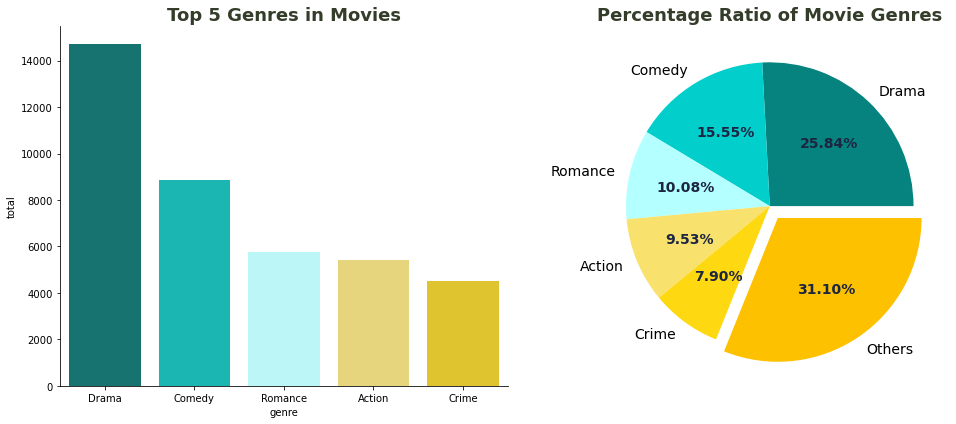

In [39]:
# Create list of genres
genres_list = []
for i in imdb_wiki['genres']:
    genres_list.extend(i.split(','))

# Instantiate plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Create barplot
df_plot = pd.DataFrame(Counter(genres_list).most_common(5), columns=['genre', 'total'])
ax = sns.barplot(data=df_plot, x='genre', y='total', ax=axes[0], 
                 palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])

ax.set_title('Top 5 Genres in Movies', fontsize=18, weight=600, color='#333d29')
sns.despine()

# Create pie chart
df_plot_full = pd.DataFrame([Counter(genres_list)]).transpose().sort_values(by=0, ascending=False)
df_plot.loc[len(df_plot)] = {'genre': 'Others', 'total':df_plot_full[6:].sum()[0]}
plt.title('Percentage Ratio of Movie Genres', fontsize=18, weight=600, color='#333d29')

wedges, texts, autotexts = axes[1].pie(x=df_plot['total'], labels=df_plot['genre'], autopct='%.2f%%',
                                       textprops=dict(fontsize=14), 
                                       explode=[0,0,0,0,0,0.1], 
                                       colors=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100'])

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')

axes[1].axis('off')

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Movie Genres Pie.png');

From the above, we can see a few takeaways:

* Drama is the single most dominant genre with over 14000 movies.
* Out of the top 5 genres, there are still many genres in the dataset. They hold 31.10% of the total genres of the movies.

Let's see if we can look at all of the genres in a different format.

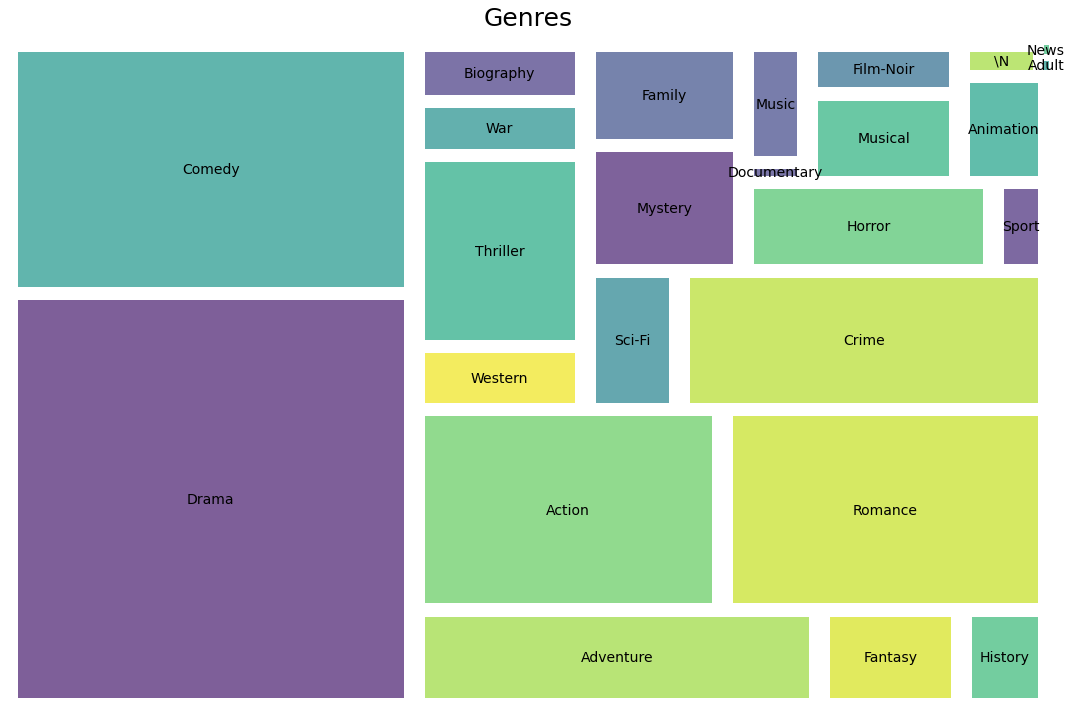

In [40]:
genres_info = Counter(genres_list)

plt.figure(figsize=(15, 10))
plt.title("Genres", fontsize=25, pad=20)
squarify.plot(genres_info.values(), label=genres_info.keys(), text_kwargs={'fontsize':14}, 
              bar_kwargs={'alpha':.7}, pad=True)
plt.axis("off")

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Movie Genres Grid.png');

We have the same data as our first visual, but this time we can see all of the genres. 

Next, let's take a look to see what year our movies were released.

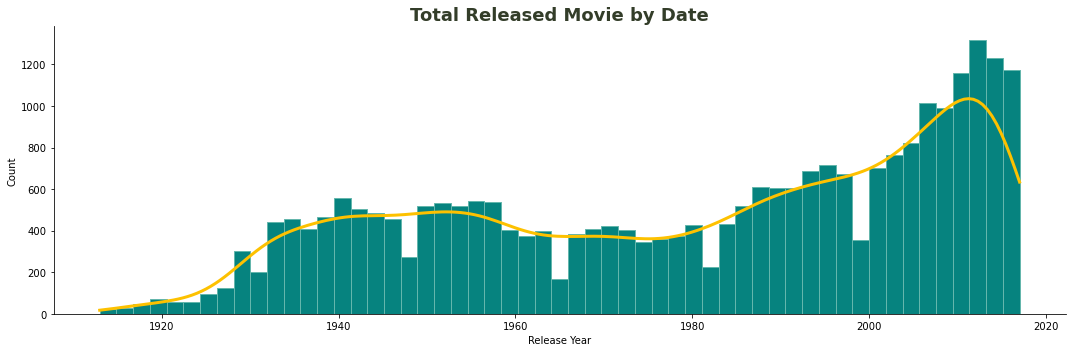

In [41]:
# Change Release Year to integer
imdb_wiki['Release Year'] = imdb_wiki['Release Year'].astype(int)

sns.displot(data=imdb_wiki, x='Release Year', kind='hist', kde=True, bins=55,
            color='#fdc100', facecolor='#06837f', edgecolor='#64b6ac', line_kws={'lw': 3}, aspect=3)

plt.title('Total Released Movie by Date', fontsize=18, weight=600, color='#333d29')

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Movie By Release Year.png');

As we can see above, our dataset is skewed left. Once again, this logically makes sense as before because more content is produced in recent years.

## Modeling

Now that we have a good understanding of our dataframe, we can start creating our second model. As a reminder, we are going to create a model that takes in the below as inputs.

* The genre of the movie
* The director of the movie
* Major stars and cast

In the below cells, we are going to use a vectorizer to build document vectors. One thing we address is that actors could have the same first name, for example such as *Tom Hanks* and *Tom Cruise*. These are clearly 2 different people but as of now, our vectorizer would just look at the name *Tom* as a separate entity. 

Therefore, we are going to strip the spaces between the genres, cast, and director's names. Therefore, in our example we will now have *tomhanks* and *tomcruise* to differentiate between our two actors. 

In [42]:
# Function to sanitize data to prevent ambiguity. 
# Removes spaces and converts to lowercase
def sanitize(x):
    if isinstance(x, list):
        #Strip spaces and convert to lowercase
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [43]:
#Apply the generate_list function to cast, director and genres
for feature in ['Cast', 'genres', 'primaryName']:
    imdb_wiki[feature] = imdb_wiki[feature].apply(sanitize)

In [44]:
# Replace commas with spaces
imdb_wiki['Cast'] = imdb_wiki['Cast'].str.replace(',', ' ')
imdb_wiki['genres'] = imdb_wiki['genres'].str.replace(',', ' ')

Let's take a look to see what the `Cast` looks like now.

In [45]:
imdb_wiki.iloc[11251]['Cast']

'timallen tomhanks(voices)'

Great! We can see that it worked.

Now we are going to create a function that merges together the `Cast`, `genres`, and `primaryName` for our vector.

In [46]:
#Function that creates a soup out of the desired metadata
def create_soup(x):
    return x['Cast'] + ' ' + x['genres'] + ' ' + x['primaryName']

In [47]:
# Create the new soup feature
imdb_wiki['soup'] = imdb_wiki.apply(create_soup, axis=1)

# Preview results
imdb_wiki.head()

Release Year                    Title  \
0          1913                 Atlantis   
1          1914  The Battle of the Sexes   
2          1914      Brewster's Millions   
3          1914      Brewster's Millions   
4          1914    The Call of the North   

                                       Cast  \
0                                             
1                    donaldcrisp liliangish   
2  edwardabeles sydneydeane josephsingleton   
3  edwardabeles sydneydeane josephsingleton   
4              robertedeson theodoreroberts   

                                                Plot  \
0  Dr. Friedrich von Kammacher (Olaf Fønss), a su...   
1  Frank Andrews (Donald Crisp) is a well-to-do, ...   
2  Wealthy Edwin Peter Brewster disowns his son R...   
3  Wealthy Edwin Peter Brewster disowns his son R...   
4  Graehme, Ned Stewart's father was accused of a...   

                                          Clean_Plot     tconst  \
0  dr friedrich von kammacher olaf fønss a surgeo...  tt0002646   
1  frank andrews donald crisp is a welltodo middl...  tt0003665   
2  wealthy edwin peter brewster disowns his son r...  tt0003698   
3  wealthy edwin peter brewster disowns his son r...  tt0003698   
4  graehme ned stewarts father was accused of adu...  tt0003743   

  runtimeMinutes           genres  averageRating  numVotes     primaryName  \
0            121            drama            6.6       424      augustblom   
1             50            drama            6.2        99    d.w.griffith   
2             \N           comedy            6.7        50  cecilb.demille   
3             \N           comedy            6.7        50      oscarapfel   
4             \N  adventure drama            5.2        45  cecilb.demille   

                                                soup  
0                                   drama augustblom  
1          donaldcrisp liliangish drama d.w.griffith  
2  edwardabeles sydneydeane josephsingleton comed...  
3  edwardabeles sydneydeane josephsingleton comed...  
4  robertedeson theodoreroberts adventure drama c...

Now that we have our `[soup]` created, we are able to create the document vectors, compute similarity scores, and build our metadata-based recommender function.

This recommendation function will follow the basic same process as before, however we will be using a `CountVectorizer` instead of the `TF-IDFVectorizer` because the `TF-IDFVectorizer` will give less weight to actors and directors who have been in a large number of movies. We do not want to penalize artists for appearing in additional movies.

Unfortunately, the `CountVectorizer` will require us to use the more computationally expensive `cosine_similarity` function to compute the scores.

In [48]:
# Instantiate the vectorizer
count = CountVectorizer(stop_words='english')

# Fit the vectorizer on `soup` and transform it
count_matrix = count.fit_transform(imdb_wiki['soup'])

# Preview the shape
count_matrix.shape

(26779, 30805)

In [49]:
# Compute cosine similarity score
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Create variable `indices2` to pull the index of each movie
indices2 = pd.Series(imdb_wiki.index, index=imdb_wiki['Title'])

In [50]:
get_recommendations('Toy Story', cosine_sim2, imdb_wiki, indices2)

Title
12055                                     Toy Story 2
12860                               The Polar Express
8566          Raggedy Ann & Andy: A Musical Adventure
8567          Raggedy Ann & Andy: A Musical Adventure
9994          Pound Puppies and the Legend of Big Paw
10280  DuckTales the Movie: Treasure of the Lost Lamp
10708                        Tom and Jerry: The Movie
11568                                        Hercules
11569                                        Hercules
15110                                   The Wild Life

We can look to comapre these results from our first model's results.

In [51]:
get_recommendations('Toy Story', cosine_sim, plots_df, indices)

Title
13574            Toy Story 2
5342    Destination Meatball
15948            Toy Story 3
5203            Puny Express
16619               Nebraska
16606                    LUV
3731   The Barber of Seville
2811        Girl from Havana
6608           Mr. B Natural
22145  It's a Boy Girl Thing

Toy Story 2 is obviously very close to Toy Story, but we can see that we do have a lot of differences from there. The `cosine_sim2` model has more children movies due to the genre, while `cosine_sim` has more plot based movies.

# Ratings Model

Now we are going to create our third type of model. One of the most basic ideas for a model is just to rank movies off of their respective ratings. However, doing a model like this has a few caveats:

* Ratings do not look at the the popularity of a movie. For example, a movie with a rating of 8.0 from 10 voters will be considered "better" than a movie with a rating of 7.9 from 10,000 voters.
* This metric will also favor movies that a smaller number of voters with extremely high ratings.

Before continuing, let's take a look at the top rated movies in our dataset.

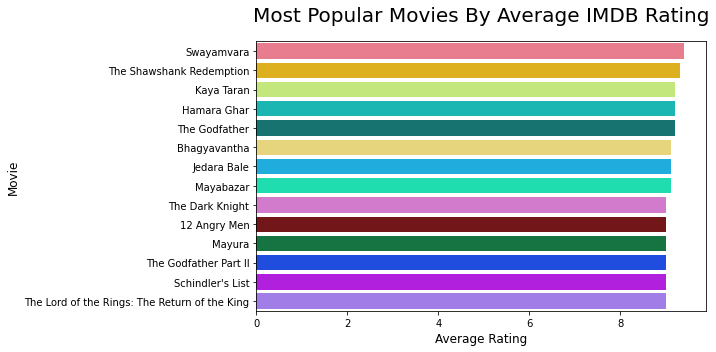

In [52]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='averageRating', ascending=False)[:15]

colors= ['#f86c83', '#fdc100', '#c9f86c', '#02cecb', '#06837f', '#f8e16c', '#00bbfd', '#00fdc1', 
         '#e16cd8', '#83060a', '#068341', '#003cfd', '#c100fd', '#9b6cf8']

# Plot the data
sns.barplot(data= top_15_popular, x='averageRating', y='Title', palette=colors)
plt.title("Most Popular Movies By Average IMDB Rating", fontsize=20, pad=20)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Movie', fontsize=12)

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/IMDB 15 Highest Rated.png');

Due to the shortcomings of just doing a model based on the average rating, we need to come up with a weighted rating that looks at the average rating as well as the number of votes that a movie has accumulated. A system like this will ensure that a movie with a 7.9 rating from 10,000 voters will get a higher quality score than a movie with a 8.0 rating from 10 voters.

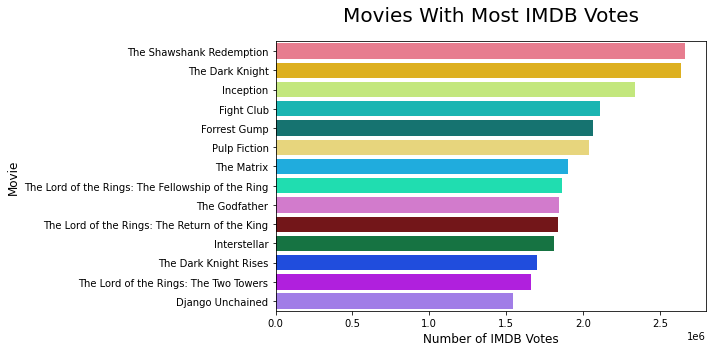

In [53]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

# Get top 15 movies
top_15_popular = imdb_wiki.sort_values(by='numVotes', ascending=False)[:16]

# Plot the data
sns.barplot(data= top_15_popular, x='numVotes', y='Title', palette=colors)
plt.title("Movies With Most IMDB Votes", fontsize=20, pad=20)
plt.xlabel('Number of IMDB Votes', fontsize=12)
plt.ylabel('Movie', fontsize=12)

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/IMDB 15 Highest Voted.png');

As we can see above, these two charts have slight differences. *The Shawshank Redemption* and *The Dark Knight* are the two most voted on movies on IMDB. However the highest average rated movies are *Swayamvara* and *The Shawshank Redemption*.

# Weighted Rating Model

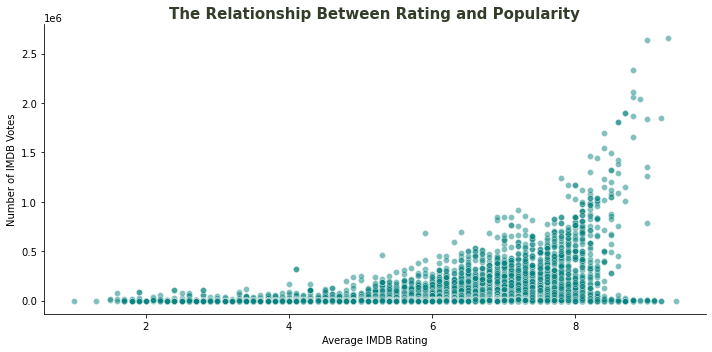

In [54]:
sns.relplot(data=imdb_wiki, x='averageRating', y='numVotes', alpha=.5, aspect=2, color='#06837f')

plt.title('The Relationship Between Rating and Popularity', fontsize=15, weight=600, color='#333d29')
plt.xlabel('Average IMDB Rating')
plt.ylabel('Number of IMDB Votes')

plt.tight_layout()

# Save our figure for later
plt.savefig('Images/Rating and Popularity.png');

As we can see in the chart above, there is a slight relationship between the average IMDB rating and the number of IMDB votes. Due to this, we are going to come up with a weighted rating that looks at both metrics. This can be represented by the below equation:

\begin{equation} \text Weighted Rating (\bf WR) = \left({{\bf v} \over {\bf v} + {\bf m}} \cdot R\right) + \left({{\bf m} \over {\bf v} + {\bf m}} \cdot C\right) \end{equation}

In this equation,

* v is the number of votes for the movie (`numVotes`)
* m is the minumum votes required to be listed in the chart
* R is the average rating for the movie (`averageRating`)
* C is the mean vote across the whole dataset

We already have the values for `v` and `R`. Additionally, we are able to directly calculate `C` from this information. One part we will need to figure out is an appropriate value for `m`. We can address this later.

First we will calculate `C`, the mean rating across all movies.

In [55]:
# Calculate C
C = imdb_wiki['averageRating'].mean()

# Display result
print(C.round(3))

6.214


From this, we can observe that an average rating for a movie in our IMDB dataset is around 6.2 on a scale of 10. Let's go ahead and calculate the score for all of the movies in our dataframe.

In [56]:
# Minumum votes to be in n-th percentile
m = 0

In [57]:
def weighted_rating(data, m=m, C=C):
    
    # Get v
    v = data['numVotes']
    
    # Get R
    R = data['averageRating']
    
    # Calculation based on the formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [58]:
# Run function
imdb_wiki['Score'] = imdb_wiki.apply(weighted_rating, axis=1)

In [59]:
# Sort by top scores
imdb_wiki = imdb_wiki.sort_values('Score', ascending=False)

# Print top 10 movies
imdb_wiki[['Title', 'averageRating', 'numVotes', 'Score']].head(5)

Title  averageRating  numVotes  Score
22505                Swayamvara            9.4        16    9.4
11036  The Shawshank Redemption            9.3   2663062    9.3
21844                Kaya Taran            9.2         7    9.2
20410               Hamara Ghar            9.2         6    9.2
8039              The Godfather            9.2   1845515    9.2

Well this is interesting. We have a lot of movies here that have basically no votes. Let's try running this again but include movies that are in the top 75% of votes received. We can use pandas for this.

In [60]:
# Minumum votes to be in n-th percentile
m = imdb_wiki['numVotes'].quantile(0.25)

print('25th Percentile:', m.round(0))

25th Percentile: 237.0


We will start by looking at movies that are in the 25th percentile of movies, meaning they need to have at least 237 votes. We will create a new dataframe to ensure that we do not mess with our original data.

In [61]:
# Filter movies in the top 75%
m25_df = imdb_wiki.copy().loc[imdb_wiki['numVotes'] > m]

# Display shape of new dataframe
m25_df.shape

(20077, 13)

In [62]:
imdb_wiki.shape

(26779, 13)

As we can see here, we filtered out roughly 25% of our movies, or movies that have received less than 237 votes. Let's take a look at the top results.

In [63]:
# Sort by top scores
m25_df = m25_df.sort_values('Score', ascending=False)

# Print top 10 movies
m25_df[['Title', 'averageRating', 'numVotes', 'Score']].head(5)

Title  averageRating  numVotes  Score
11036  The Shawshank Redemption            9.3   2663062    9.3
8039              The Godfather            9.2   1845515    9.2
24805                 Mayabazar            9.1      5149    9.1
10848          Schindler's List            9.0   1348587    9.0
24947          Aha Naa Pellanta            9.0      3056    9.0

This looks significantly better. Let's try doing this one last time but only look at movies that are in the top 10% of number of votes.

In [64]:
# Minumum votes to be in n-th percentile
m = imdb_wiki['numVotes'].quantile(0.90)

# Filter movies in the top 90%
m90_df = imdb_wiki.copy().loc[imdb_wiki['numVotes'] > m]

# Sort by top scores
m90_df = m90_df.sort_values('Score', ascending=False)

# Print top 10 movies
m90_df[['Title', 'averageRating', 'numVotes', 'Score']].head(5)

Title  averageRating  numVotes  Score
11036  The Shawshank Redemption            9.3   2663062    9.3
8039              The Godfather            9.2   1845515    9.2
17849           The Dark Knight            9.0   2636054    9.0
6130               12 Angry Men            9.0    786416    9.0
8257      The Godfather Part II            9.0   1264131    9.0

That's great. Now we have the ability to generate recommendations based on the average rating and number of votes, while taking into account a minumum number of votes needed to recommend.

# Collaborative Filtering Recommendation System

We are now going to move onto a new type of recommendation system using collaborative filtering. All of the previous recommender systems were content based, meaning they would recommend items based on analyizing item attributes and finding similar items. Pivoting to collaborative filtering, we will now create a recommendation system based on a user's previous behaviors.

<div>
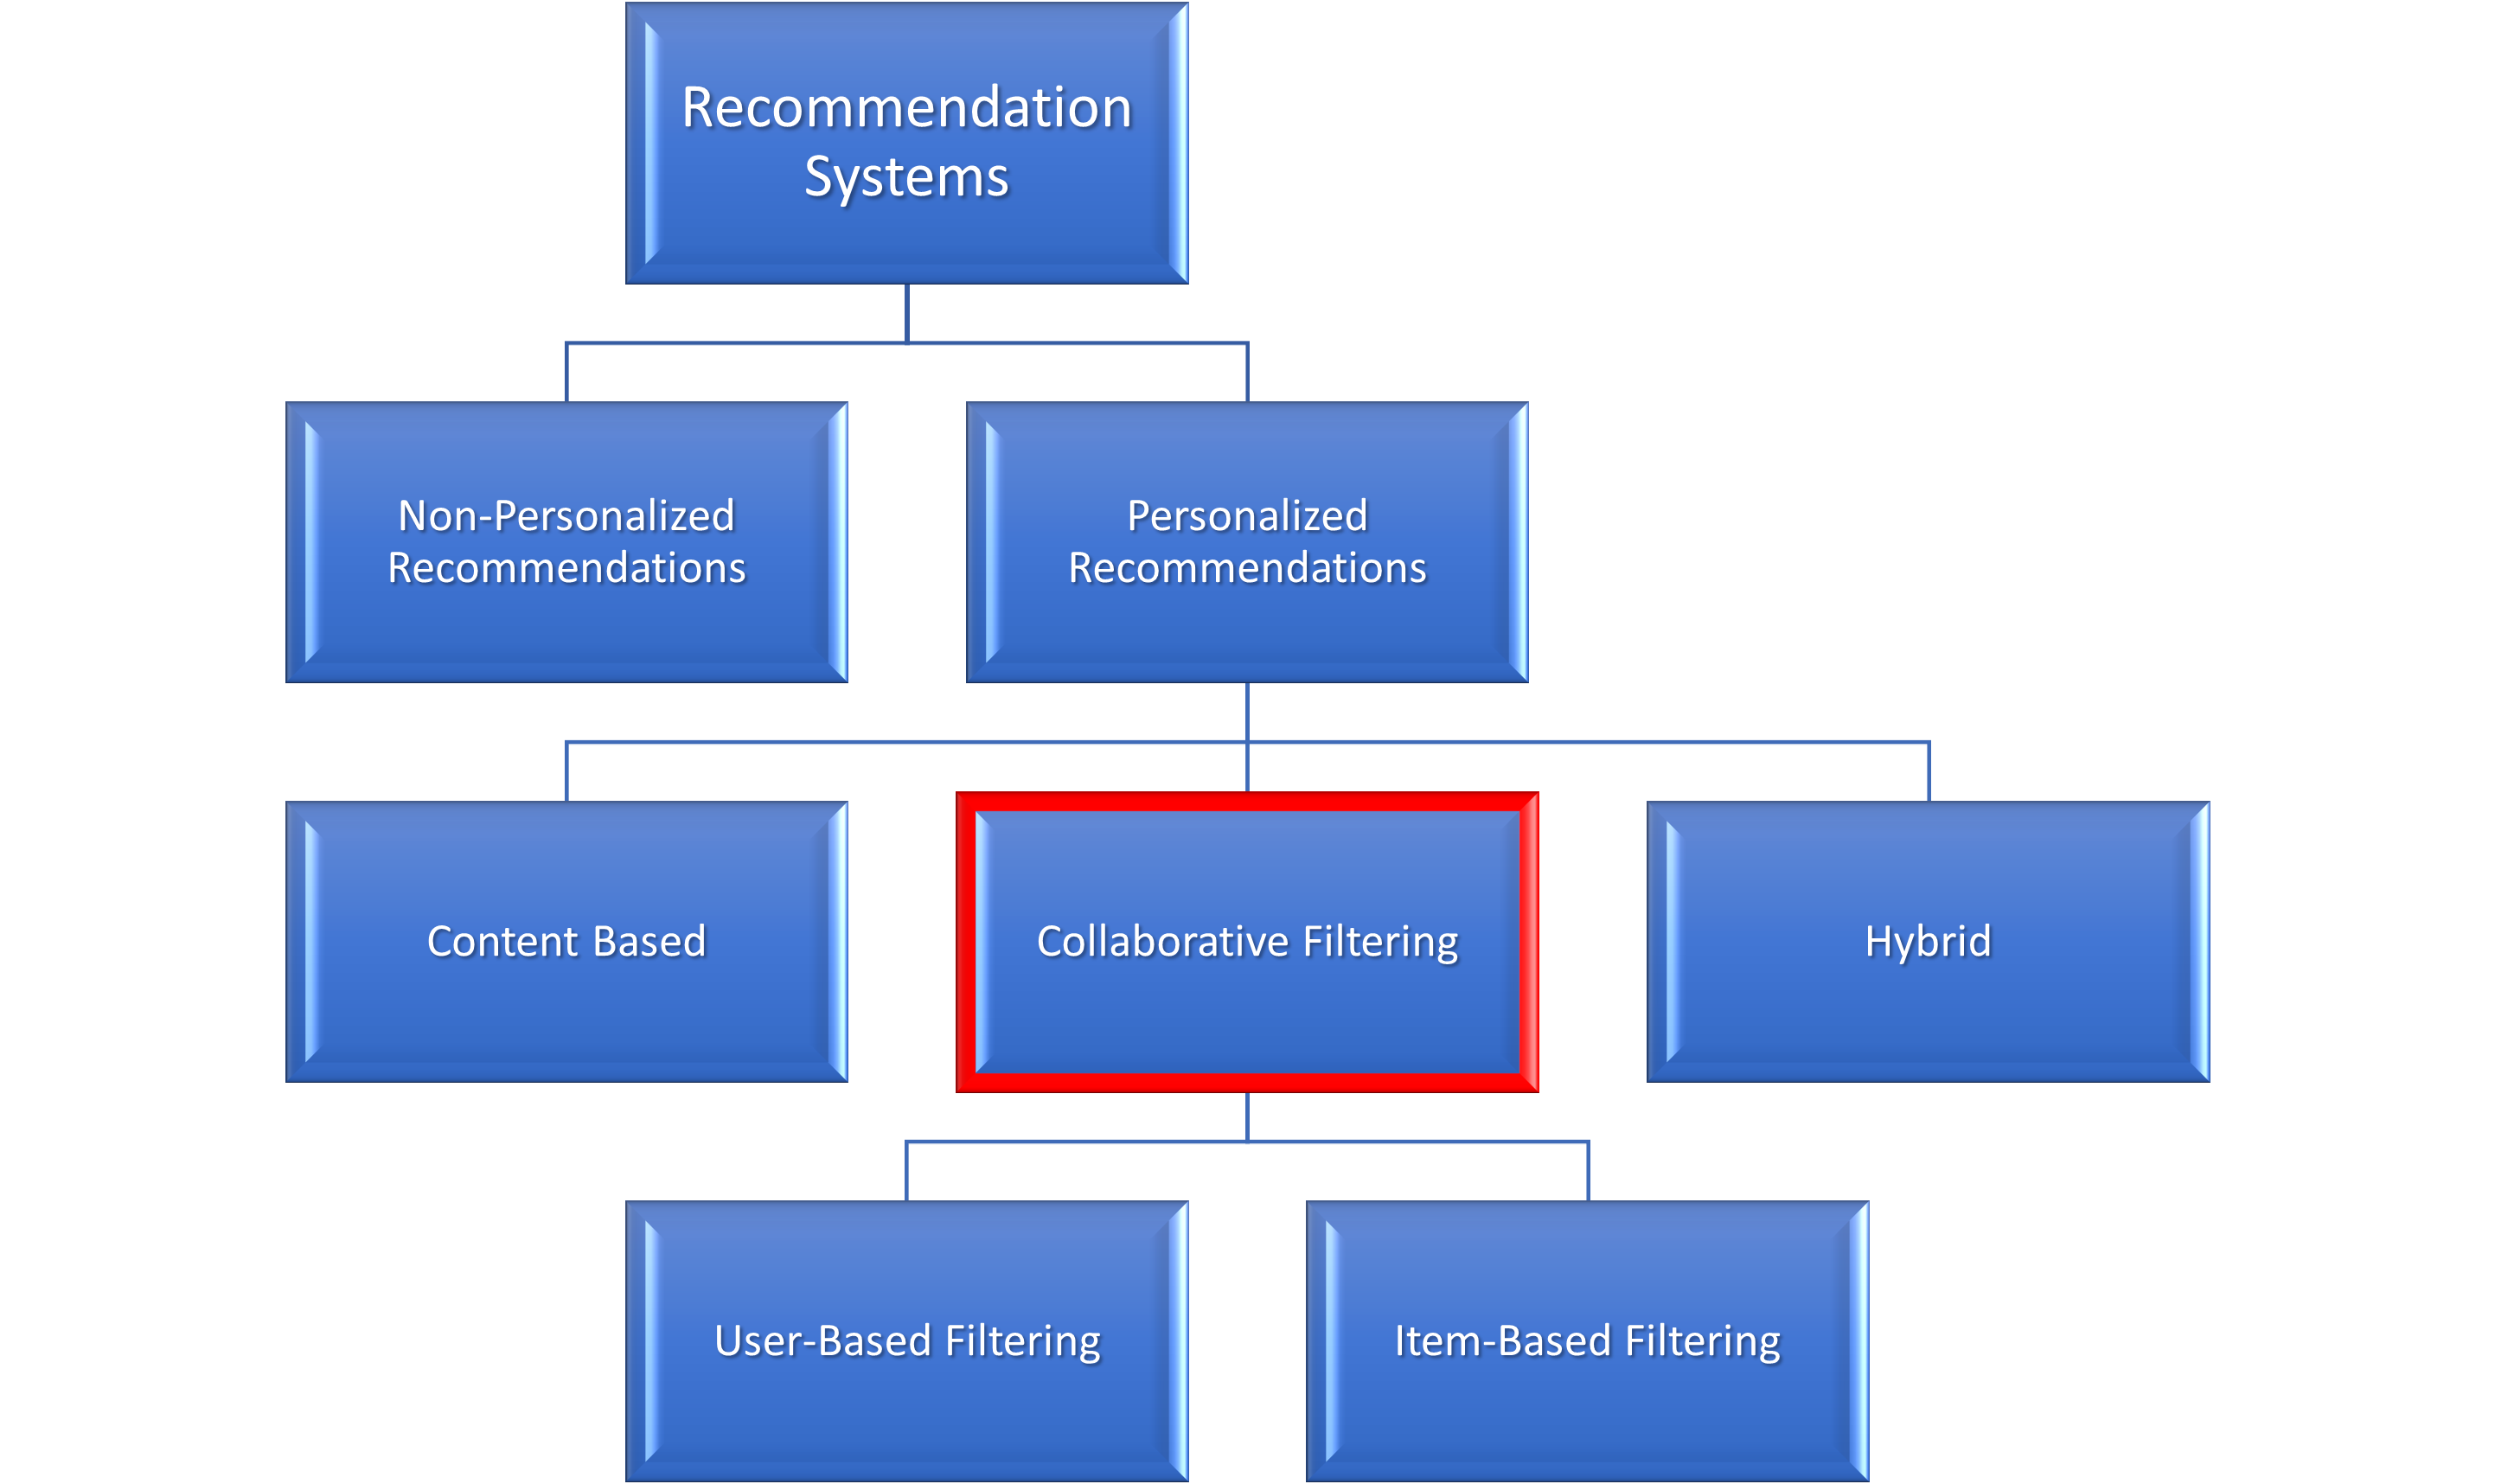
</div>

The goal of collaborative filtering systems is to provide the best user experience. Big companies such as Netflix and Amazon use these everyday and are a staple of their business model. 

## MovieLens 100K Data

There are 4 files within the MovieLens 100K dataset:

  * `links`
  * `movies`
  * `ratings`
  * `tags`

In [65]:
# Load the data
links_df = pd.read_csv('Data/MovieLens/ml-latest-small/links.csv')

# Preview the data
links_df.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [66]:
# Load the data
movies_df = pd.read_csv('Data/MovieLens/ml-latest-small/movies.csv')

# Preview the data
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [67]:
# Load the data
ratings_df = pd.read_csv('Data/MovieLens/ml-latest-small/ratings.csv')

# Preview the data
ratings_df.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Now let's try merging together the three dataframes from the MovieLens 100K dataset. Luckily they have an unique column in common - `movieId`.

In [68]:
# Merge the datasets on `movieId`
movielens_df = pd.merge(links_df, movies_df, on='movieId')

# Merge the datasets on `movieId`
movielens_df = pd.merge(movielens_df, ratings_df, on='movieId')

# Preview the results
movielens_df

movieId   imdbId    tmdbId                                      title  \
0             1   114709     862.0                           Toy Story (1995)   
1             1   114709     862.0                           Toy Story (1995)   
2             1   114709     862.0                           Toy Story (1995)   
3             1   114709     862.0                           Toy Story (1995)   
4             1   114709     862.0                           Toy Story (1995)   
...         ...      ...       ...                                        ...   
100831   193581  5476944  432131.0  Black Butler: Book of the Atlantic (2017)   
100832   193583  5914996  445030.0               No Game No Life: Zero (2017)   
100833   193585  6397426  479308.0                               Flint (2017)   
100834   193587  8391976  483455.0        Bungo Stray Dogs: Dead Apple (2018)   
100835   193609   101726   37891.0        Andrew Dice Clay: Dice Rules (1991)   

                                             genres  userId  rating  \
0       Adventure|Animation|Children|Comedy|Fantasy       1     4.0   
1       Adventure|Animation|Children|Comedy|Fantasy       5     4.0   
2       Adventure|Animation|Children|Comedy|Fantasy       7     4.5   
3       Adventure|Animation|Children|Comedy|Fantasy      15     2.5   
4       Adventure|Animation|Children|Comedy|Fantasy      17     4.5   
...                                             ...     ...     ...   
100831              Action|Animation|Comedy|Fantasy     184     4.0   
100832                     Animation|Comedy|Fantasy     184     3.5   
100833                                        Drama     184     3.5   
100834                             Action|Animation     184     3.5   
100835                                       Comedy     331     4.0   

         timestamp  
0        964982703  
1        847434962  
2       1106635946  
3       1510577970  
4       1305696483  
...            ...  
100831  1537109082  
100832  1537109545  
100833  1537109805  
100834  1537110021  
100835  1537157606  

[100836 rows x 8 columns]

In [69]:
# Checking for missing values
movielens_df.isna().sum()

movieId       0
imdbId        0
tmdbId       13
title         0
genres        0
userId        0
rating        0
timestamp     0
dtype: int64

We won't be using the `tmdbId` column so we can drop that entirely from our dataframe.

In [70]:
# Drop the column
movielens_df.drop('tmdbId', axis=1, inplace=True)

In [71]:
# Checking if it worked
movielens_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   imdbId     100836 non-null  int64  
 2   title      100836 non-null  object 
 3   genres     100836 non-null  object 
 4   userId     100836 non-null  int64  
 5   rating     100836 non-null  float64
 6   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.2+ MB


Unfortunately we do not have a 100% distinct column in both the `movielens_df` and `imdb_wiki` dataframes. 

However, the column `imdbId` from `movielens_df` is appropriate to use for matching this dataset to the `imdb_wiki` dataset using `tconst`. Let's take a look at this below:

In [72]:
# Preview the first line
movielens_df[:1]

movieId  imdbId             title  \
0        1  114709  Toy Story (1995)   

                                        genres  userId  rating  timestamp  
0  Adventure|Animation|Children|Comedy|Fantasy       1     4.0  964982703

As we can see, Toy Story has an `imdbId` of `114709`. What is even better is that this matches up with the link to Toy Story on IMDB's website.

> Toy Story: https://www.imdb.com/title/tt0114709/

Let's see if Toy Story appears in our `imdb_wiki` dataframe.

In [73]:
# Check for `imdbId` value
imdb_wiki.loc[imdb_wiki['tconst'].str.contains('114709')]

Release Year      Title                       Cast  \
11251          1995  Toy Story  timallen tomhanks(voices)   

                                                    Plot  \
11251  In a world where toys are living things who pr...   

                                              Clean_Plot     tconst  \
11251  in a world where toys are living things who pr...  tt0114709   

      runtimeMinutes                      genres  averageRating  numVotes  \
11251             81  adventure animation comedy            8.3    989855   

        primaryName                                               soup  Score  
11251  johnlasseter  timallen tomhanks(voices) adventure animation ...    8.3

Well that actually works well for us. Before going any further, let's try looking at some additional examples:

In [74]:
# Pull another random sample
movielens_df[3695:3700]

movieId  imdbId               title                genres  userId  \
3695      111   75314  Taxi Driver (1976)  Crime|Drama|Thriller     411   
3696      111   75314  Taxi Driver (1976)  Crime|Drama|Thriller     414   
3697      111   75314  Taxi Driver (1976)  Crime|Drama|Thriller     415   
3698      111   75314  Taxi Driver (1976)  Crime|Drama|Thriller     418   
3699      111   75314  Taxi Driver (1976)  Crime|Drama|Thriller     419   

      rating   timestamp  
3695     4.0   835532253  
3696     5.0   961516639  
3697     4.5  1382470177  
3698     4.5  1461866063  
3699     4.0  1321659216

In [75]:
# Cross reference the `movieId`
imdb_wiki.loc[imdb_wiki['tconst'].str.contains('75314')]

Release Year                     Title  \
8486           1976               Taxi Driver   
19262          2016  My Best Friend's Wedding   

                                                    Cast  \
8486   robertdeniro jodiefoster cybillshepherd harvey...   
19262  shuqi fengshaofeng victoriasong yeqing rhydian...   

                                                    Plot  \
8486   Travis Bickle, a 26-year-old honorably dischar...   
19262  A successful fashion editor realizes she has r...   

                                              Clean_Plot     tconst  \
8486   travis bickle a 26yearold honorably discharged...  tt0075314   
19262  a successful fashion editor realizes she has r...  tt5275314   

      runtimeMinutes         genres  averageRating  numVotes     primaryName  \
8486             114    crime drama            8.2    828016  martinscorsese   
19262             91  drama romance            5.1       338     feihongchen   

                                                    soup  Score  
8486   robertdeniro jodiefoster cybillshepherd harvey...    8.2  
19262  shuqi fengshaofeng victoriasong yeqing rhydian...    5.1

Well that is interesting. We have two `tconst` matches for our one `movieId` column.

After doing a little digging, it is easy to tell that all of the movies we are looking for start with the `tconst` of `tt0`. Let's drop all of the rows from our `imdb_df` that do not include that code:

In [76]:
# Preview the original shape
imdb_wiki.shape

(26779, 13)

In [77]:
# Filter out movies not containing `tt0`
imdb_wiki = imdb_wiki.loc[imdb_wiki['tconst'].str.contains('tt0')]

print(imdb_wiki.shape, '\n')
imdb_wiki.head()

(20676, 13) 



Release Year                     Title  \
11036          1994  The Shawshank Redemption   
21844          2004                Kaya Taran   
20410          1964               Hamara Ghar   
8039           1972             The Godfather   
22533          1981              Bhagyavantha   

                                                    Cast  \
11036  timrobbins morganfreeman jameswhitmore clancyb...   
21844  seemabiswas angadbedi neelambaribhattacharya n...   
20410  dilipraj surekha sonalmehta rekharao nanapalsi...   
8039   marlonbrando alpacino jamescaan robertduvall j...   
22533  masterlohith aarathi jaijagadish leelavathi k....   

                                                    Plot  \
11036  In 1947 Portland, Maine, banker Andy Dufresne ...   
21844  Preet is a shy young journalist visiting a con...   
20410  Children from different social backgrounds and...   
8039   In 1945, at his daughter Connie's wedding, Vit...   
22533  The movie stars and revolves around the life o...   

                                              Clean_Plot     tconst  \
11036  in 1947 portland maine banker andy dufresne is...  tt0111161   
21844  preet is a shy young journalist visiting a con...  tt0470399   
20410  children from different social backgrounds and...  tt0150816   
8039   in 1945 at his daughter connies wedding vito c...  tt0068646   
22533  the movie stars and revolves around the life o...  tt0260737   

      runtimeMinutes       genres  averageRating  numVotes  \
11036            142        drama            9.3   2663062   
21844            107        drama            9.2         7   
20410             \N           \n            9.2         6   
8039             175  crime drama            9.2   1845515   
22533             \N           \n            9.1        82   

              primaryName                                               soup  \
11036       frankdarabont  timrobbins morganfreeman jameswhitmore clancyb...   
21844          sashikumar  seemabiswas angadbedi neelambaribhattacharya n...   
20410    khwajaahmadabbas  dilipraj surekha sonalmehta rekharao nanapalsi...   
8039   francisfordcoppola  marlonbrando alpacino jamescaan robertduvall j...   
22533           rangab.s.  masterlohith aarathi jaijagadish leelavathi k....   

       Score  
11036    9.3  
21844    9.2  
20410    9.2  
8039     9.2  
22533    9.1

It appears that we filtered out about ~20% of the rows from our `imdb_wiki`. However, now we should not have any overlaps when we are trying to merge our two datasets. 

In order to merge the two datasets, we need to change the `imdbId` column into an string so it matches `tconst`. Let's drop the first 3 digits from our `tconst` column so it will match `imdbId` and then change the `imdbId` column to a string.

In [78]:
# Slice each column in `tconst`
imdb_wiki['tconst'] = imdb_wiki['tconst'].str[3:]

# Preview the results
imdb_wiki.head()

Release Year                     Title  \
11036          1994  The Shawshank Redemption   
21844          2004                Kaya Taran   
20410          1964               Hamara Ghar   
8039           1972             The Godfather   
22533          1981              Bhagyavantha   

                                                    Cast  \
11036  timrobbins morganfreeman jameswhitmore clancyb...   
21844  seemabiswas angadbedi neelambaribhattacharya n...   
20410  dilipraj surekha sonalmehta rekharao nanapalsi...   
8039   marlonbrando alpacino jamescaan robertduvall j...   
22533  masterlohith aarathi jaijagadish leelavathi k....   

                                                    Plot  \
11036  In 1947 Portland, Maine, banker Andy Dufresne ...   
21844  Preet is a shy young journalist visiting a con...   
20410  Children from different social backgrounds and...   
8039   In 1945, at his daughter Connie's wedding, Vit...   
22533  The movie stars and revolves around the life o...   

                                              Clean_Plot  tconst  \
11036  in 1947 portland maine banker andy dufresne is...  111161   
21844  preet is a shy young journalist visiting a con...  470399   
20410  children from different social backgrounds and...  150816   
8039   in 1945 at his daughter connies wedding vito c...  068646   
22533  the movie stars and revolves around the life o...  260737   

      runtimeMinutes       genres  averageRating  numVotes  \
11036            142        drama            9.3   2663062   
21844            107        drama            9.2         7   
20410             \N           \n            9.2         6   
8039             175  crime drama            9.2   1845515   
22533             \N           \n            9.1        82   

              primaryName                                               soup  \
11036       frankdarabont  timrobbins morganfreeman jameswhitmore clancyb...   
21844          sashikumar  seemabiswas angadbedi neelambaribhattacharya n...   
20410    khwajaahmadabbas  dilipraj surekha sonalmehta rekharao nanapalsi...   
8039   francisfordcoppola  marlonbrando alpacino jamescaan robertduvall j...   
22533           rangab.s.  masterlohith aarathi jaijagadish leelavathi k....   

       Score  
11036    9.3  
21844    9.2  
20410    9.2  
8039     9.2  
22533    9.1

In [79]:
# Change `imdbId` to a string
movielens_df['imdbId'] = movielens_df['imdbId'].astype('str')

In [80]:
# Merge the two datasets
movielens_imdb = pd.merge(movielens_df, imdb_wiki, left_on='imdbId', right_on='tconst')

# Preview the results
movielens_imdb.head()

movieId  imdbId             title  \
0        1  114709  Toy Story (1995)   
1        1  114709  Toy Story (1995)   
2        1  114709  Toy Story (1995)   
3        1  114709  Toy Story (1995)   
4        1  114709  Toy Story (1995)   

                                      genres_x  userId  rating   timestamp  \
0  Adventure|Animation|Children|Comedy|Fantasy       1     4.0   964982703   
1  Adventure|Animation|Children|Comedy|Fantasy       5     4.0   847434962   
2  Adventure|Animation|Children|Comedy|Fantasy       7     4.5  1106635946   
3  Adventure|Animation|Children|Comedy|Fantasy      15     2.5  1510577970   
4  Adventure|Animation|Children|Comedy|Fantasy      17     4.5  1305696483   

   Release Year      Title                       Cast  \
0          1995  Toy Story  timallen tomhanks(voices)   
1          1995  Toy Story  timallen tomhanks(voices)   
2          1995  Toy Story  timallen tomhanks(voices)   
3          1995  Toy Story  timallen tomhanks(voices)   
4          1995  Toy Story  timallen tomhanks(voices)   

                                                Plot  \
0  In a world where toys are living things who pr...   
1  In a world where toys are living things who pr...   
2  In a world where toys are living things who pr...   
3  In a world where toys are living things who pr...   
4  In a world where toys are living things who pr...   

                                          Clean_Plot  tconst runtimeMinutes  \
0  in a world where toys are living things who pr...  114709             81   
1  in a world where toys are living things who pr...  114709             81   
2  in a world where toys are living things who pr...  114709             81   
3  in a world where toys are living things who pr...  114709             81   
4  in a world where toys are living things who pr...  114709             81   

                     genres_y  averageRating  numVotes   primaryName  \
0  adventure animation comedy            8.3    989855  johnlasseter   
1  adventure animation comedy            8.3    989855  johnlasseter   
2  adventure animation comedy            8.3    989855  johnlasseter   
3  adventure animation comedy            8.3    989855  johnlasseter   
4  adventure animation comedy            8.3    989855  johnlasseter   

                                                soup  Score  
0  timallen tomhanks(voices) adventure animation ...    8.3  
1  timallen tomhanks(voices) adventure animation ...    8.3  
2  timallen tomhanks(voices) adventure animation ...    8.3  
3  timallen tomhanks(voices) adventure animation ...    8.3  
4  timallen tomhanks(voices) adventure animation ...    8.3

In [81]:
movielens_imdb.columns

Index(['movieId', 'imdbId', 'title', 'genres_x', 'userId', 'rating',
       'timestamp', 'Release Year', 'Title', 'Cast', 'Plot', 'Clean_Plot',
       'tconst', 'runtimeMinutes', 'genres_y', 'averageRating', 'numVotes',
       'primaryName', 'soup', 'Score'],
      dtype='object')

We can see that we have a good amount of duplicated and unnecessary columns, let's go ahead and filter out the columns we actually want to keep.

In [82]:
# Filter out columns we want
movielens_imdb_df = movielens_imdb[['Title', 'imdbId', 'Release Year', 'Plot', 'soup', 'genres_x',
                                    'userId', 'rating', 'runtimeMinutes', 'averageRating', 'numVotes', 'Score']]

# Preview new dataframe
print('Dataframe Length:', movielens_imdb_df.shape[0])
movielens_imdb_df.head()

Dataframe Length: 59022


Title  imdbId  Release Year  \
0  Toy Story  114709          1995   
1  Toy Story  114709          1995   
2  Toy Story  114709          1995   
3  Toy Story  114709          1995   
4  Toy Story  114709          1995   

                                                Plot  \
0  In a world where toys are living things who pr...   
1  In a world where toys are living things who pr...   
2  In a world where toys are living things who pr...   
3  In a world where toys are living things who pr...   
4  In a world where toys are living things who pr...   

                                                soup  \
0  timallen tomhanks(voices) adventure animation ...   
1  timallen tomhanks(voices) adventure animation ...   
2  timallen tomhanks(voices) adventure animation ...   
3  timallen tomhanks(voices) adventure animation ...   
4  timallen tomhanks(voices) adventure animation ...   

                                      genres_x  userId  rating runtimeMinutes  \
0  Adventure|Animation|Children|Comedy|Fantasy       1     4.0             81   
1  Adventure|Animation|Children|Comedy|Fantasy       5     4.0             81   
2  Adventure|Animation|Children|Comedy|Fantasy       7     4.5             81   
3  Adventure|Animation|Children|Comedy|Fantasy      15     2.5             81   
4  Adventure|Animation|Children|Comedy|Fantasy      17     4.5             81   

   averageRating  numVotes  Score  
0            8.3    989855    8.3  
1            8.3    989855    8.3  
2            8.3    989855    8.3  
3            8.3    989855    8.3  
4            8.3    989855    8.3

Let's make a copy of this dataframe that includes only the information we need for our collaborative filtering recommendation system.

In [83]:
# Slice out columns we want
collab_df = movielens_imdb_df[['Title', 'userId', 'imdbId', 'rating']]

# Preview results
collab_df.head()

Title  userId  imdbId  rating
0  Toy Story       1  114709     4.0
1  Toy Story       5  114709     4.0
2  Toy Story       7  114709     4.5
3  Toy Story      15  114709     2.5
4  Toy Story      17  114709     4.5

### Train Test Split

Our `collab_df` contains user ratings that range from 0.5 to 5.0. Therefore, we can model this problem as an instance of supervised learning where we need to predict the rating, given a user and a movie. Although the ratings can only take in ten discrete values, we will model this as a regression problem.

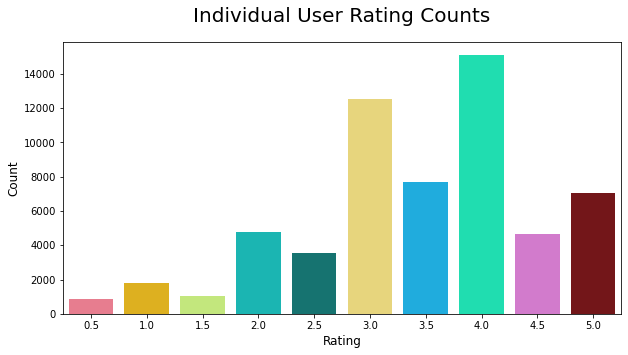

In [84]:
# Create the plot
fig, ax = plt.subplots(figsize=(10,5))

sns.countplot(data=movielens_imdb_df, x='rating', palette=colors)
plt.title("Individual User Rating Counts", fontsize=20, pad=20)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12);

Think about an example where the rating given by a user to a movie is a 5.0. A classification model will not distinguish between the predicted ratings of 1.0 and 4.0 but rather treate both as misclassified. However, a regression model will penalize the 1.0 more than the 4.0, which is what we want to happen.

We are going to split the `collab_df` so that 75% of a user's ratings are in the training dataset and 25% are in the testing dataset, which will require us do the `train_test_split` in a bit of an odd way. We will assume that the `userId` field is the target variable (or y) and that the other columns are the predictor variables (or X). We will perform a `train_test_split` and set stratify to `y` to ensure that the proportion of each class is the same in the training and testing datasets.

In [85]:
#Assign X and y 
X = collab_df.copy()
y = collab_df['userId']

# Perform train test split with random_state = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, stratify=y)

### Evaluation

We are going to use root mean squared error to assess our model performance as it is the most commonly used performance metric for regressors. We are going to create a function that returns to square root value.

In [86]:
# Create function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Now we are going to make a baseline collaborative filter model. This model will take in a `userId` and `imdbId` as input and return a float between 0.5 and 5.0. We make our baseline model will return a 3.0 regardless of `userId` and `imdbId`.

In [87]:
# Baseline model that returns 3.0
def baseline(userId, imdbId):
    return 3.0

To test how effective this model is, we will compute the RMSE for all user-IMDB pairs in the test dataset:

In [88]:
def score(cf_model):
    
    # List of user-IMDB tuples in testing data
    pairs = zip(X_test['userId'], X_test['imdbId'])
    
    # Predict the rating for every tuple
    y_pred = np.array([cf_model(user, movie) for (user, movie) in pairs])
    
    # Get actual ratings
    y_true = np.array(X_test['rating'])
    
    # Return score
    return rmse(y_true, y_pred)

Now let's compute the RMSE for our baseline model:

In [89]:
# Calculate score
score(baseline)

1.1410280327568652

Great. We got a score of 1.141. For the models that we will build after this, we will try to obtain a RMSE that is less than this baseline model.

## User-Based Collaborative Filtering

We are first going to create a user-based collaborative filter. This type of filter finds users that are similar to a particular user and then recommends products that those users have liked.

<div>
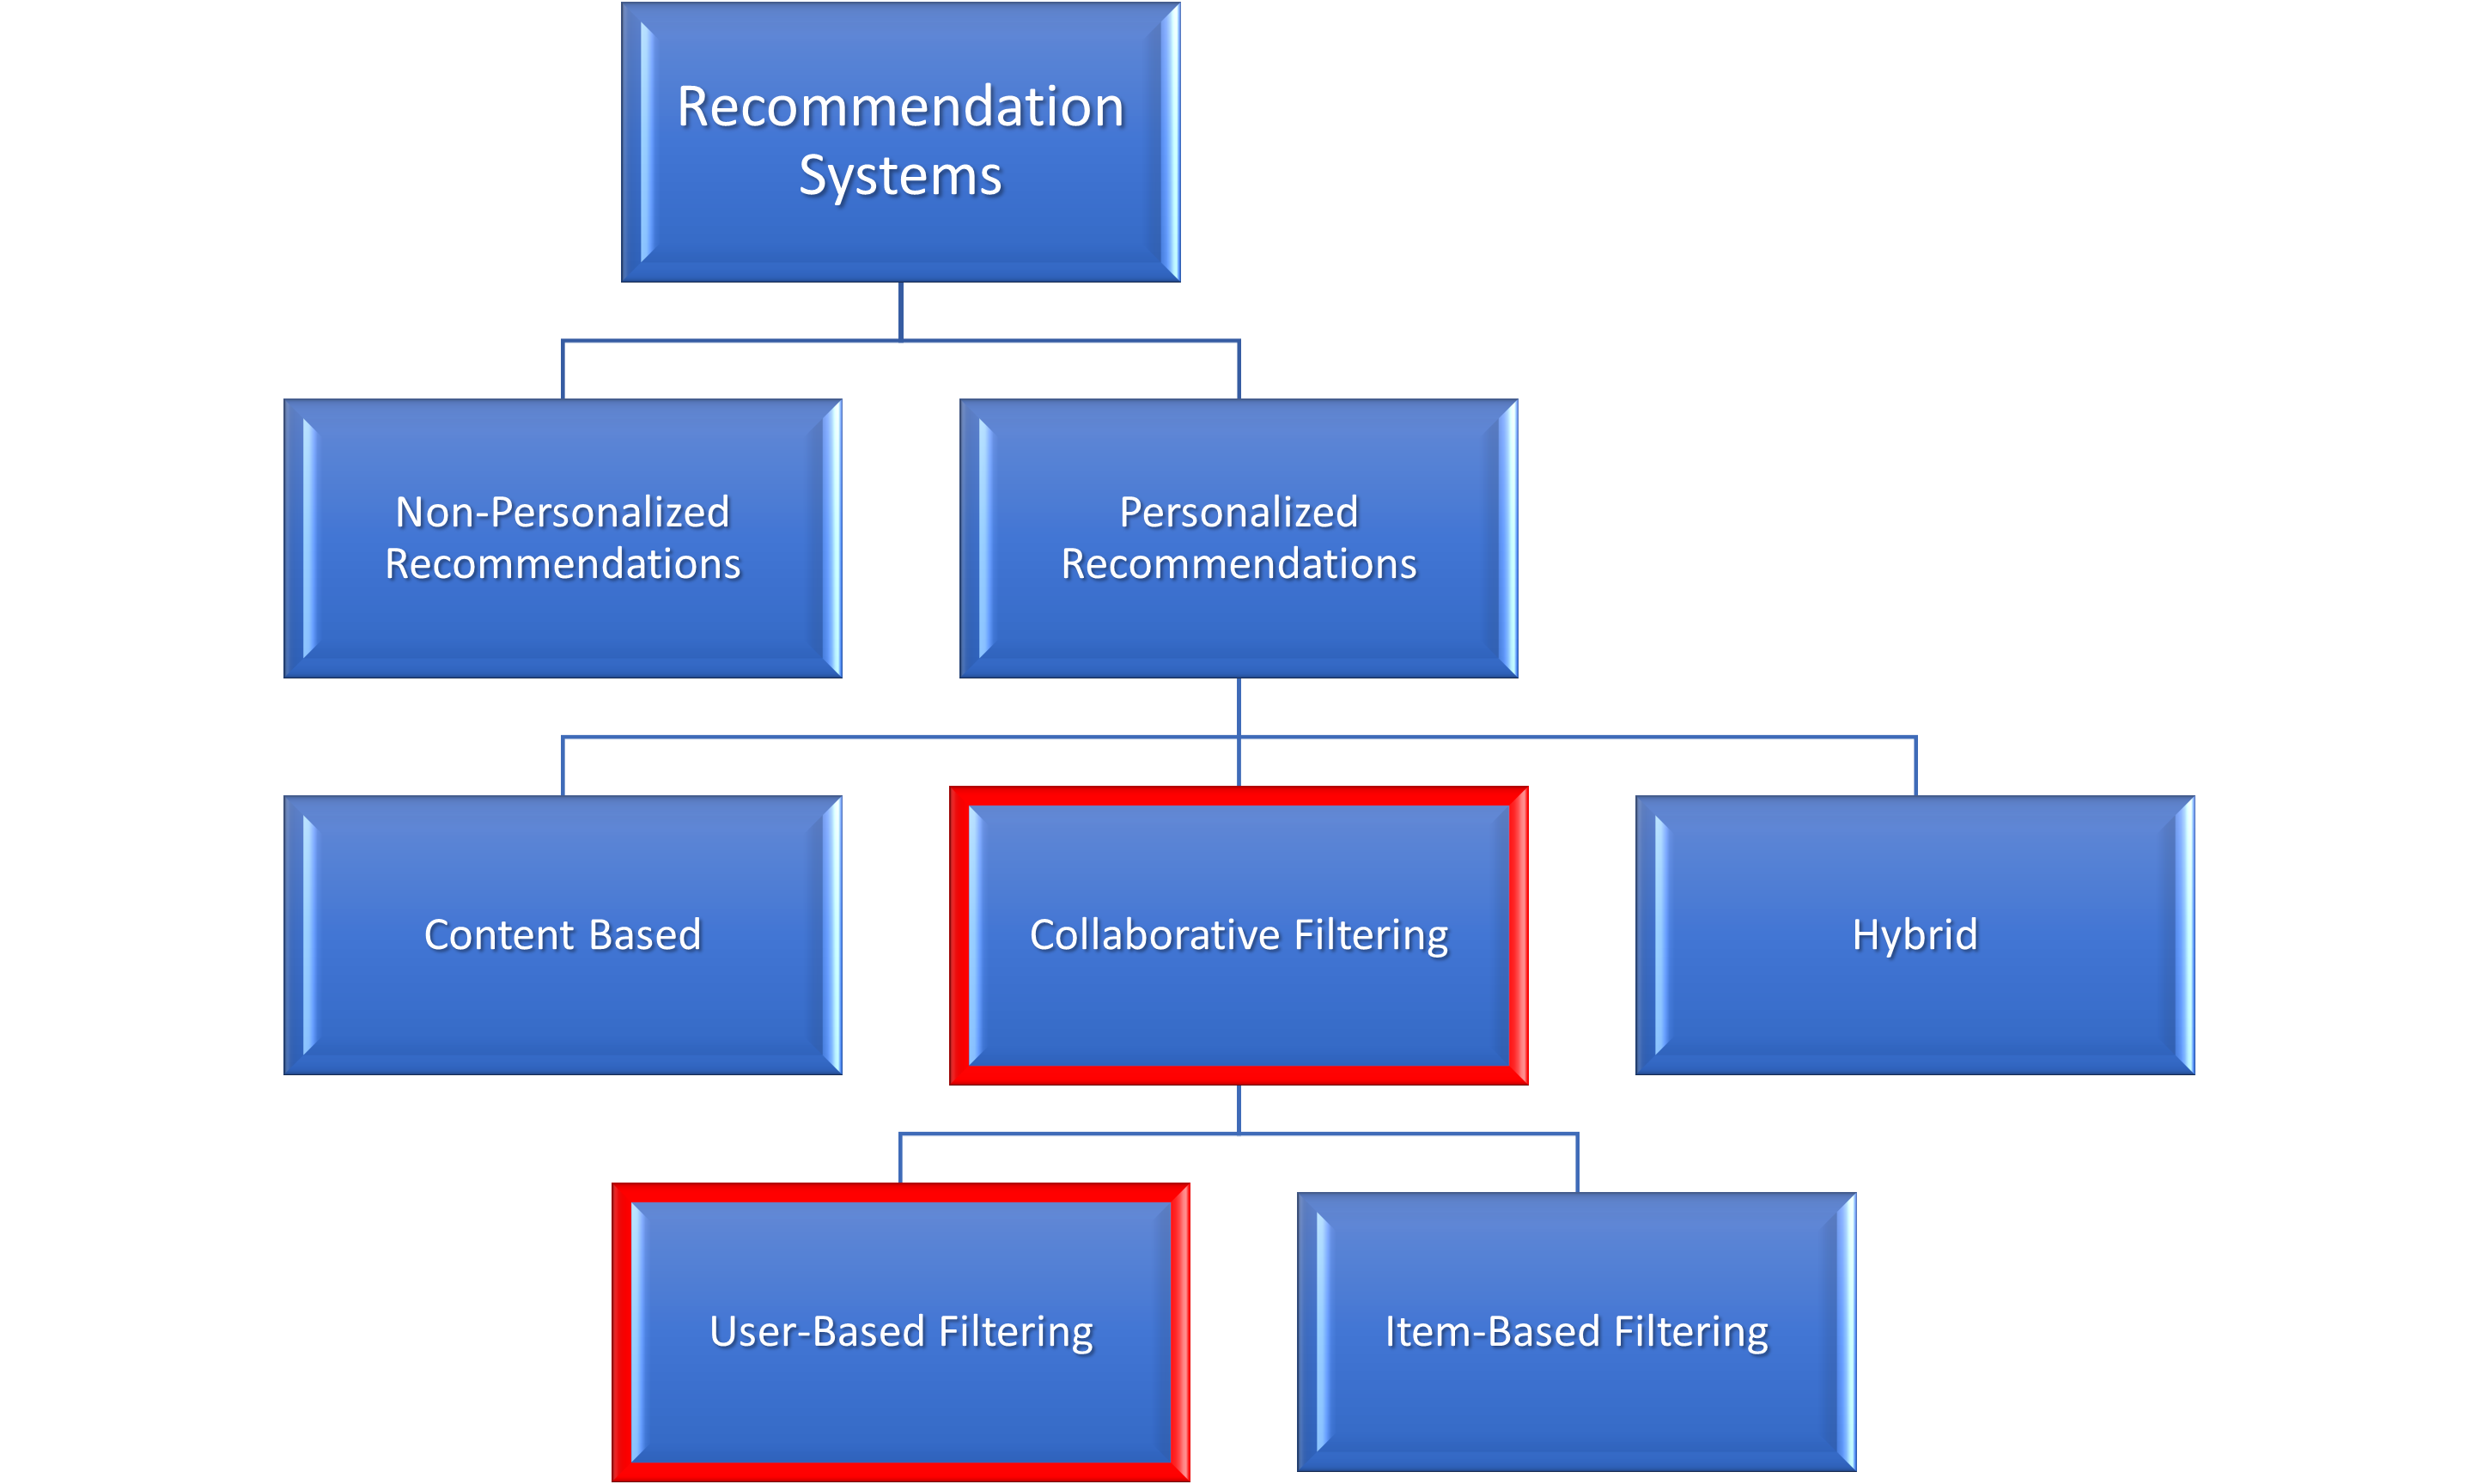
</div>

We are first going to build a ratings matrix where each row represents a user and each column represents a movie. Therefore, the value in the i<sup>th</sup> row and j<sup>th</sup> column will denote the rating given by user i and movie j.

In [90]:
# Ratings matrix
r_matrix = X_train.pivot_table(values='rating', index='userId', columns='imdbId')

r_matrix.head()

imdbId  100029  100046  100050  100053  100054  100087  100114  100133  \
userId                                                                   
1          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5          NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

imdbId  100140  100142  ...  981227  985694  986233  986263  988045  988047  \
userId                  ...                                                   
1          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4          NaN     2.0  ...     NaN     NaN     NaN     NaN     NaN     NaN   
5          NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

imdbId  988595  990407  993842  997047  
userId                                  
1          NaN     NaN     NaN     NaN  
2          NaN     NaN     NaN     NaN  
3          NaN     NaN     NaN     NaN  
4          NaN     NaN     NaN     NaN  
5          NaN     NaN     NaN     NaN  

[5 rows x 2779 columns]

We now have a new dataframe where each row is a user and each column is a movie. We can see that most values are NaN, which makese sense as most users will not have seen most movies.

## Mean Model

We will start by building a simple collaborative filter. This will take in a `userId` and `imdbId` and output the mean rating for the movie by everyone who has rated it. This filter will not distinguish between users meaning each user is assigned equal weight. 

It is also possible that some movies will only be in the test set and not the training set, therefore we will give a default rating of 3.0 like our baseline model:

In [91]:
def cf_user_mean(userId, imdbId):
    
    # Check if movie is in our r_matrix
    if imdbId in r_matrix:
        
        # Compute the mean
        mean_rating = r_matrix[imdbId].mean()
        
    else:
        
        # Default 3.0
        mean_rating = 3.0
        
    return mean_rating

In [92]:
# RMSE for Mean model
score(cf_user_mean)

0.9629955053948778

Fantastic! We can see that the score obtained for this model is lower (and better) than our baseline model.

| **Type of Model** | **RMSE** |
|:-----------------:|:--------:|
|   Baseline Model  |   1.141  |
|     Mean Model    |   0.963  |

## Item-Based Collaborative Filtering

These models are the same as the last type, except users now play the role that the items played. According to [Towards Data Science](https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d) it was developed by Amazon in 1998 and plays a great role in Amazon's success.


<div>
<img src="attachment:Item%20Based%20Filtering-2.png" width="700"/>
</div>

At the core, item-based collaborative filters are all about finding items similar to the ones that a user has already liked. For example, let's assume that Maddie enjoyed movies 'A', 'B', and 'C'. We will then search for movies that are similar to those three movies. If we found a movie 'D', that is highly similar to one, two, or three of 'A', 'B', or 'C', we would recommend movie 'D' to Maddie because it is very similar to movies she already watched.

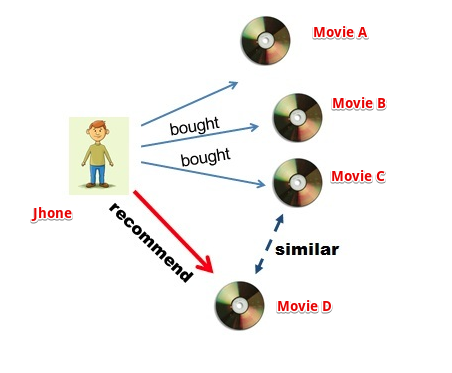



We can use a few different filters for the models that we will use in this part of the notebook.

### Clustering

Using clustering, such as k-means, it is possible to group users into a cluster and only take the users from the same clusters into consideration when predicting ratings. We will use a [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) given a user a movie:

1. Find the k-nearest neighbors of users who have rated the movie
2. Output the average rating of the nearest users for the movie

All of this can be doing using the `surprise` library, which stands for **Simple Python Recommendation System Engine**. From the [Surprise website](https://surpriselib.com/), the library was designed with the following purposes in mind:

* Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
* Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
* Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
* Make it easy to implement new algorithm ideas.
* Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

In [93]:
# Get rid of `Title` column
surprise_df = collab_df[['userId', 'imdbId', 'rating']]

In [94]:
# Define Reader Object
reader = Reader(rating_scale=(0.5, 5))

# Create dataset to be used
data = Dataset.load_from_df(surprise_df, reader)

# Define object
knn = KNNBasic()

# Evaluate the performance in RMSE
knn_basic = cross_validate(knn, data, measures=['RMSE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [95]:
# Display results
for i in knn_basic.items():
    print(i)

print('Test RMSE:', np.mean(knn_basic['test_rmse']))

('test_rmse', array([0.89118626, 0.90854747, 0.88272059, 0.89198773, 0.89686209]))
('fit_time', (0.1337285041809082, 0.12353634834289551, 0.11852121353149414, 0.12767648696899414, 0.12151288986206055))
('test_time', (0.8466362953186035, 0.8886082172393799, 0.8203072547912598, 0.8332135677337646, 0.8233234882354736))
Test RMSE: 0.8942608306732838


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.893  |

We can see here that the `cross_validate` used a five fold cross validation score. We can also see here that we received a RMSE of 0.896 which is by far the best score we have obtained so far. 

We can try one other KNN object, the KNN Baseline.

In [96]:
# Define object
knn = KNNBaseline()

# Evaluate the performance in RMSE
knn_baseline = cross_validate(knn, data, measures=['RMSE'])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [97]:
# Display results
for i in knn_baseline.items():
    print(i)

print('Test RMSE:', np.mean(knn_baseline['test_rmse']))

('test_rmse', array([0.81529834, 0.84103445, 0.82112237, 0.83831017, 0.82903806]))
('fit_time', (0.1996936798095703, 0.20580172538757324, 0.23226642608642578, 0.2211592197418213, 0.23455095291137695))
('test_time', (1.1497042179107666, 1.2828028202056885, 1.1479220390319824, 1.2096748352050781, 1.01373291015625))
Test RMSE: 0.8289606793130126


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.894  |
|  KNN Baseline (Item Based)  |   0.830  |

Once again, we beat our best performing model with a RMSE of 0.830.

In [98]:
# Define object
knn = KNNWithMeans()

# Evaluate the performance in RMSE
knn_with_means = cross_validate(knn, data, measures=['RMSE'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [99]:
# Display results
for i in knn_with_means.items():
    print(i)

print('Test RMSE:', np.mean(knn_with_means['test_rmse']))

('test_rmse', array([0.85196352, 0.85784331, 0.84982576, 0.84987871, 0.85290026]))
('fit_time', (0.11569023132324219, 0.12777137756347656, 0.12304806709289551, 0.12252187728881836, 0.1245417594909668))
('test_time', (0.8291013240814209, 0.8906514644622803, 0.9114911556243896, 0.8279929161071777, 0.8284802436828613))
Test RMSE: 0.8524823104206277


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.894  |
|  KNN Baseline (Item Based)  |   0.830  |
| KNN With Means (Item Based) |   0.852  |

This model did not perform as well as our baseline KNN model.

### Singular-Value Decomposition

Principal Component Analysis (or PCA) transforms a *m x n* matrix into n, m-dimensional vectors (or principal components) in such a way that each component is orthogonal to the next component. It also constructs these components in such a way that the first component holds the most variance (or information), followed by the second component, and so on.

The classic version of Singular-Value Decomposition (SVD), like most other machine learning algorithms, does not work with sparse matrices. However, Simon Funk figured out a workaround for this problem, and his solution led to one of the most famous solutions in the world of recommender systems.

Funk's system took in the sparse ratings matrix, A, and constructed two dense user- and item-embedding matrices, U and V respectively. These dense matrices directly gave us the predictions for all the missing values in the original matrix, A.

Fortunately, there is a nice package in surprise to help implement this model.

In [100]:
# Define object
svd = SVD()

# Evaluate the performance in RMSE
svd_baseline = cross_validate(svd, data, measures=['RMSE'])

In [101]:
# Display results
for i in svd_baseline.items():
    print(i)

print('Test RMSE:', np.mean(svd_baseline['test_rmse']))

('test_rmse', array([0.83224508, 0.82692726, 0.82779021, 0.8219303 , 0.82969574]))
('fit_time', (2.002436876296997, 2.208024740219116, 2.079338550567627, 2.0356616973876953, 2.040337562561035))
('test_time', (0.05951285362243652, 0.059513092041015625, 0.11638522148132324, 0.05894827842712402, 0.05578327178955078))
Test RMSE: 0.8277177190718698


|      **Type of Model**      | **RMSE** |
|:---------------------------:|:--------:|
| Baseline Model (User Based) |   1.141  |
|   Mean Model (User Based)   |   0.963  |
|    KNN Basic (Item Based)   |   0.893  |
|  KNN Baseline (Item Based)  |   0.830  |
| KNN With Means (Item Based) |   0.852  |
|       SVD (Item Based)      |   0.828  |

Great! We can see here that we beat our previous KNN models with our first SVD model. Now we can try a `GridSearchCV` to see if we can beat this SVD Baseline model.

In [102]:
# Set up parameters
params = {'n_factors': [20, 50, 100, 150],
         'reg_all': [0.02, 0.05, 0.1]}

# Perform a gridsearch with SVD
gs_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)

# Fit on our data
gs_svd.fit(data)

In [103]:
print(gs_svd.best_score)
print(gs_svd.best_params)

{'rmse': 0.8239052617155023, 'mae': 0.6258859731024067}
{'rmse': {'n_factors': 150, 'reg_all': 0.02}, 'mae': {'n_factors': 150, 'reg_all': 0.02}}


|         **Type of Model**        | **RMSE** |
|:--------------------------------:|:--------:|
|    Baseline Model (User Based)   |   1.141  |
|      Mean Model (User Based)     |   0.963  |
|      KNN Basic (Item Based)      |   0.893  |
|     KNN Baseline (Item Based)    |   0.830  |
|    KNN With Means (Item Based)   |   0.852  |
|         SVD (Item Based)         |   0.828  |
| SVD With GridSearch (Item Based) |   0.824  |

We can see here that our GridSearch helped us *slightly* beat the previous SVD model with a RMSE of 0.824.

## Making Recommendations

While it is great that we achieved a low RMSE, this is in no way interpretable to people. Let's start off by making a simple prediction for an individual user and item. First we will build out our trainset and fit our best SVD model with the proper parameters.

In [104]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  609 

Number of items:  2908


In [105]:
# Instatiate the object
svd = SVD(n_factors=150, reg_all=0.02)

# Fit SVD
svd.fit(dataset)

Now, we will get a rating prediction for a user (in the below case #432) and a movid ID (in this case #111161 - The Shawshank Redemption).

In [106]:
# Predict user's rating for a movie
svd.predict(432, 111161)

Prediction(uid=432, iid=111161, r_ui=None, est=3.413993595477837, details={'was_impossible': False})

This prediction is a tuple and the values can be accessed via indexing. This means that user #432 would have an estimated rating of 3.72 for The Shawshank Redemption.

# Hybrid Recommendation

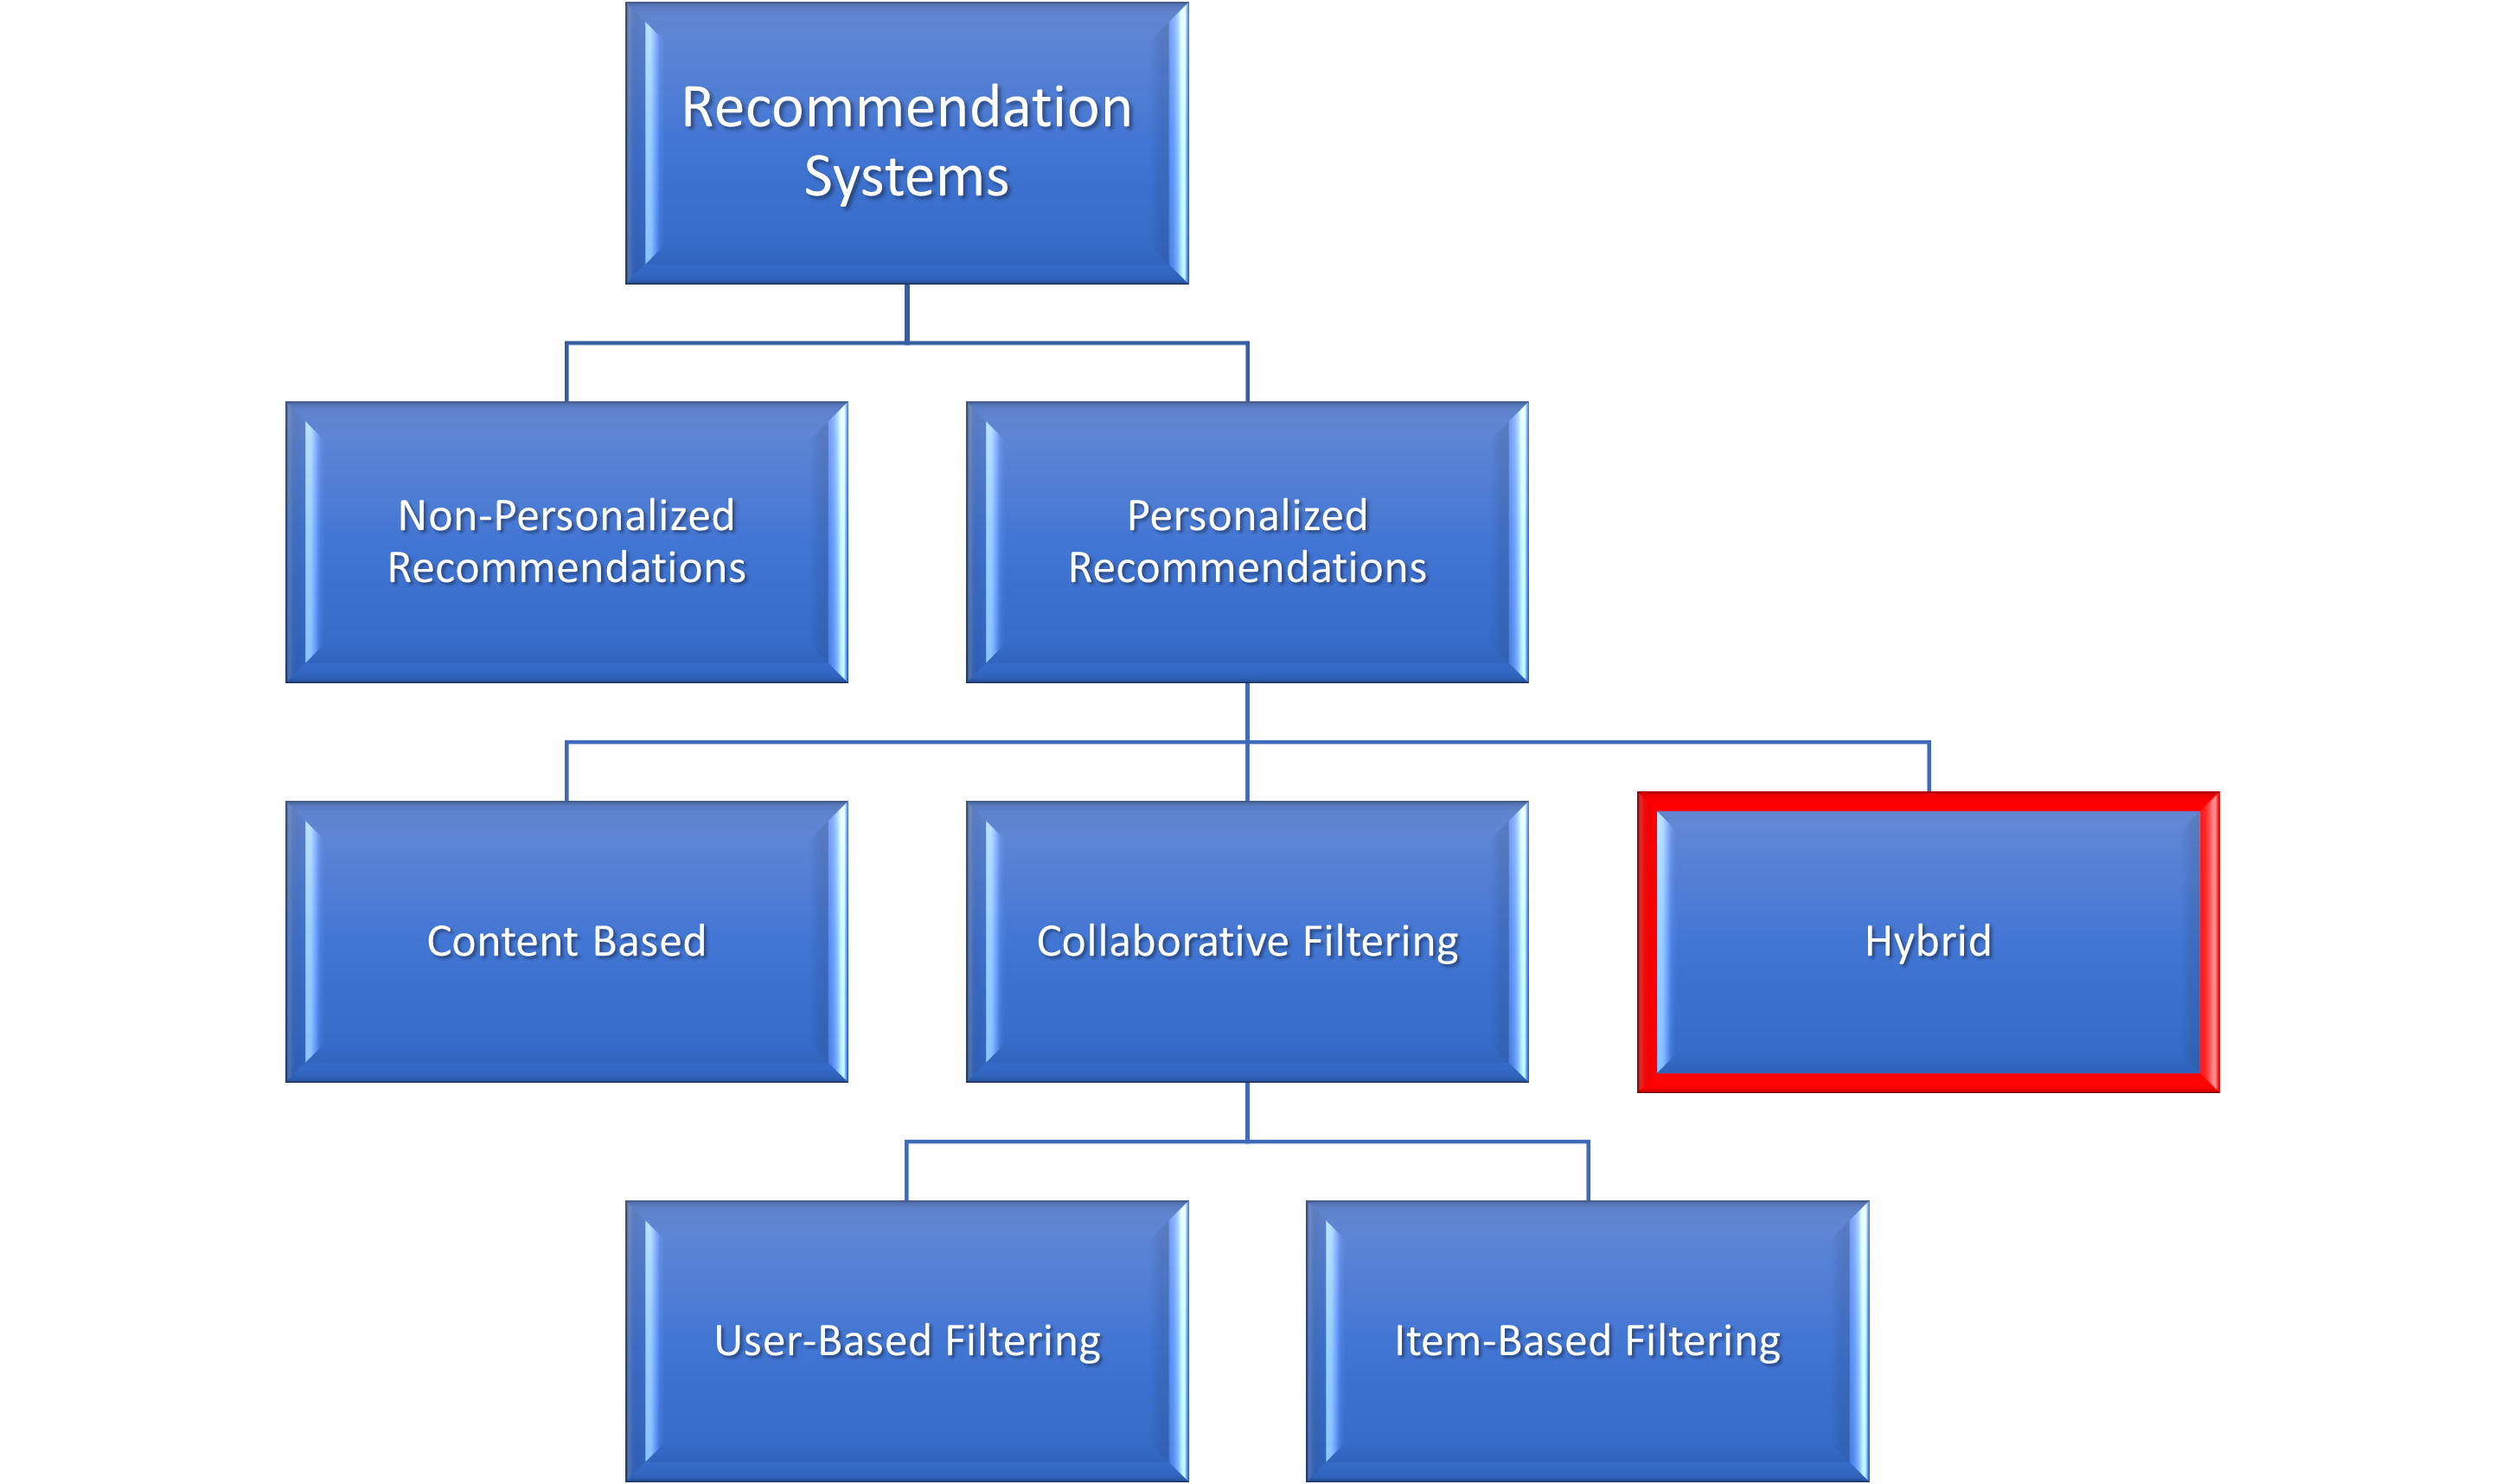

Hybrid recommenders are powerful, robust systems that combine various simpler models to give predictions. There is no correct way for a hybrid model to function - some use content and collaborative filtering techniques separately while others use content based techniques in collaborative filters.

Netflix is great example of a hybrid recommender. They have one line that typical includes a section *Because you watched This*, which is a content-based technique to show movies similar to movies you have viewed in the past. And then there can be another section such as *Top Picks*, which is a collaborative filtering technique to identify users who have liked movies that are similar to movies I have watched.

<div>
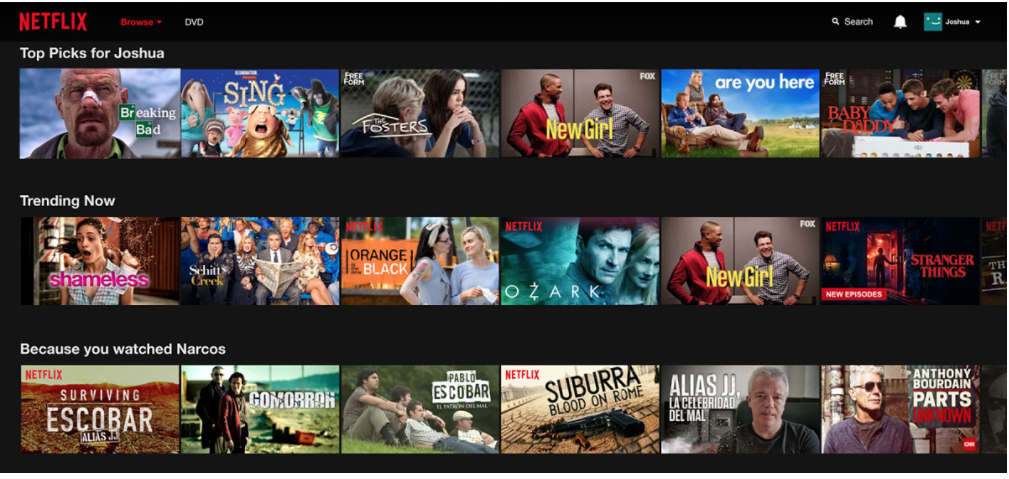
</div>

We are going to create a hybrid recommendation function that uses content and collaborative filtering techniques. First, we will pair down our `movielens_imdb_df` to include movies that have achieved a certain score and a specific number of votes (content based filter). From there we will load our new dataframe into `Surprise` and run a SVD package (collaborative filter).

First we will take a look at our existing dataframe.

In [107]:
# View number of movies
print('Current Number of Movies:', movielens_imdb_df.shape[0])

Current Number of Movies: 59022


In [108]:
# Filter by score of 6.0+ and more than 500k votes
hybrid_df = movielens_imdb_df[(movielens_imdb_df['Score'] > 7.75)]

# View new number of movies
print('Hybrid Number of Movies:', hybrid_df.shape[0])

Hybrid Number of Movies: 15282


Great, we can see here that we have filtered out roughly 75% of the movies and are left with the top 25%. Now our dataframe is ready for `Surprise`.

In [109]:
# Filter columns for Surprise
hybrid_surprise_df = hybrid_df[['userId', 'imdbId', 'rating']]

In [110]:
# Define Reader Object
reader = Reader(rating_scale=(0.5, 5))

# Create dataset to be used
data = Dataset.load_from_df(hybrid_surprise_df, reader)

# Define object
svd = SVD()

# Evaluate the performance in RMSE
svd_baseline = cross_validate(svd, data, measures=['RMSE'])

In [111]:
# Display results
for i in svd_baseline.items():
    print(i)

print('Test RMSE:', np.mean(svd_baseline['test_rmse']))

('test_rmse', array([0.75371148, 0.73705124, 0.72019342, 0.71685225, 0.75663502]))
('fit_time', (0.49764013290405273, 0.5096695423126221, 0.49048328399658203, 0.4920797348022461, 0.5464737415313721))
('test_time', (0.014507770538330078, 0.014032363891601562, 0.014667749404907227, 0.017905712127685547, 0.014005899429321289))
Test RMSE: 0.7368886790983499


|         **Type of Model**        | **RMSE** |
|:--------------------------------:|:--------:|
|    Baseline Model (User Based)   |   1.141  |
|      Mean Model (User Based)     |   0.963  |
|      KNN Basic (Item Based)      |   0.893  |
|     KNN Baseline (Item Based)    |   0.830  |
|    KNN With Means (Item Based)   |   0.852  |
|         SVD (Item Based)         |   0.828  |
| SVD With GridSearch (Item Based) |   0.824  |
|           Hybrid Model           |   0.741  |

Well look at that! Our hybrid recommendation system is the best performing one yet. This makes sense because movies that have more votes will more likely be easier to predict ratings. 

# Movies for Apple TV+

Now that we know that using the top performing movies with a score greater than 7.75 reduces our RMSE, we are going to use this data to hypertune a `Surprise` algorithm.

First, we are going to rotate through the below algorthims to see which one has the lowest RMSE:

### **Basic algorithms**

**NormalPredictor**
* `NormalPredictor` algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal. This is one of the most basic algorithms that do not do much work.

**BaselineOnly**
* `BaselineOnly` algorithm predicts the baseline estimate for given user and item.

### **k-NN algorithms**

**KNNBasic**
* `KNNBasic` is a basic collaborative filtering algorithm.

**KNNWithMeans**
* `KNNWithMeans` is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

**KNNWithZScore**
* `KNNWithZScore` is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.

**KNNBaseline**
* `KNNBaseline` is a basic collaborative filtering algorithm taking into account a baseline rating.

### **Matrix Factorization-based algorithms**

**SVD**
* `SVD` algorithm is equivalent to Probabilistic Matrix Factorization

**SVDpp**
* The `SVDpp` algorithm is an extension of SVD that takes into account implicit ratings.

**NMF**
* `NMF` is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

### Slope One

* `SlopeOne` is a straightforward implementation of the SlopeOne algorithm.

### Co-clustering

* `Coclustering` is a collaborative filtering algorithm based on co-clustering.

In [112]:
benchmark = []

# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), 
                  KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp, pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)
    
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [113]:
# Preview results
surprise_results

test_rmse  fit_time  test_time
Algorithm                                      
KNNBaseline       0.732795  0.047798   0.604975
KNNWithZScore     0.748409  0.064451   0.545803
KNNWithMeans      0.749819  0.046152   0.497768
SVDpp             0.759204  3.665558   0.152436
SVD               0.759697  0.397057   0.023815
KNNBasic          0.778495  0.055842   0.555422
SlopeOne          0.793378  0.013666   0.073171
BaselineOnly      0.795714  0.005999   0.014003
NMF               0.799005  0.456402   0.040462
CoClustering      0.838674  0.149916   0.016193
NormalPredictor   1.192734  0.008668   0.014334

`KNNBaseline` algorithm gave us the lowest RMSE, therefore, we will train and predict with `KNNBaseline`.

## Results

Utilizing the `KNNBaseline` hybrid model, we are able to generate predictions that have a RMSE of 0.739 (out of 5). By running this model through our dataset, we are able to generate predictions for each user and every movie in our dataset. When we look at the average estimated rating by title, we can determine what movies our users are most likely to resonate with based on their previous choices. 

In [114]:
# Define parameters
param_grid = {'K': [25, 30, 35, 40, 45, 50, 55], 'min_k': [1, 2, 3, 4, 5]}

In [115]:
# Instantiate object
algo = KNNBaseline(bsl_options=param_grid)

# Cross validate
cross_validate(algo, data, cv=3)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.74003872, 0.73737494, 0.73159836]),
 'test_mae': array([0.53865671, 0.5428779 , 0.52879269]),
 'fit_time': (0.046004295349121094, 0.04608654975891113, 0.04768776893615723),
 'test_time': (0.5789768695831299, 0.57952880859375, 0.5700674057006836)}

We use the `train_test_split()` to sample a trainset and a testset with given sizes, and use the accuracy metric of rmse. We’ll then use the `fit()` method which will train the algorithm on the trainset, and the `test()` method which will return the predictions made from the testset.

In [116]:
# Perform train_test_split
trainset, testset = train_test_split_surprise(data, test_size=0.25, random_state=32)

# Load in param_grid
algo = KNNBaseline(bsl_options=param_grid)

# Fit on training set and test our testset
predictions = algo.fit(trainset).test(testset)

# Get RMSE
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7437


0.7436739187312642

In [117]:
trainset = algo.trainset
print(algo.__class__.__name__)

KNNBaseline


To inspect our predictions in details, we are going to build a pandas data frame with all the predictions. The following function will help accomplish this with these columns:

* `UID`: user-id
* `iid`: item id
* `Rui`: the rating given by the user
* `est`: rating estimated by the model
* `Iu`: No of items rated by the user
* `UI`: number of users that have rated this item
* `err`: abs difference between predicted rating and the actual rating.

In [118]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [119]:
# Preview results
df.head()

uid     iid  rui       est                                    details  Iu  \
0  159  107290  3.0  3.586871  {'actual_k': 40, 'was_impossible': False}  25   
1  275  102926  5.0  4.332772  {'actual_k': 40, 'was_impossible': False}  37   
2  318  120815  3.5  4.088786  {'actual_k': 40, 'was_impossible': False}  75   
3  187  111161  3.0  4.181347  {'actual_k': 40, 'was_impossible': False}  49   
4  227  103064  3.5  4.215165  {'actual_k': 40, 'was_impossible': False}  25   

    Ui       err  
0  169  0.586871  
1  207  0.667228  
2  142  0.588786  
3  235  1.181347  
4  175  0.715165

Now lets look at the 10 best and worst predictions our model made:

In [120]:
# Sort by error
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [121]:
# View top 10
best_predictions

uid     iid  rui  est                                    details  Iu  \
1024  122  116282  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  49   
2248   74  116282  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  24   
310   124  116282  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  15   
972   523  110357  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  18   
2634  234  110357  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  14   
986   400  133093  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  16   
1678  302  116282  5.0  5.0  {'actual_k': 40, 'was_impossible': False}   4   
2960  246  133093  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  37   
182   106  133093  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  10   
2953  452  116282  5.0  5.0  {'actual_k': 40, 'was_impossible': False}  16   

       Ui  err  
1024  255  0.0  
2248  255  0.0  
310   255  0.0  
972   257  0.0  
2634  257  0.0  
986   416  0.0  
1678  255  0.0  
2960  416  0.0  
182   416  0.0  
2953  255  0.0

The above are the best predictions, and they are not lucky guesses. Because Ui is anywhere between 158 to 411, they are not  small, meaning that significant number of users have rated the target movie.

It's interesting to note that these perfect predictions are actually lucky shots: |Ui| is always very small, meaning that very few users have rated the target item. This implies that the set of neighbors is very small (see the actual_k field)... And, it just happens that all the ratings from the neighbors are the same (and mostly, are equal to that of the target user).

In [122]:
# View bottom 10
worst_predictions

uid     iid  rui       est                                    details  \
1079  115  169547  1.0  4.279476  {'actual_k': 40, 'was_impossible': False}   
239   393  499549  0.5  3.786824  {'actual_k': 40, 'was_impossible': False}   
1662  275  106332  1.0  4.287364   {'actual_k': 5, 'was_impossible': False}   
3374  322  120601  0.5  3.853715  {'actual_k': 40, 'was_impossible': False}   
850   393  103064  0.5  4.047569  {'actual_k': 40, 'was_impossible': False}   
566   393  117951  0.5  4.082944  {'actual_k': 40, 'was_impossible': False}   
1744  301  103064  0.5  4.083960  {'actual_k': 40, 'was_impossible': False}   
2358  522  790636  0.5  4.228830  {'actual_k': 10, 'was_impossible': False}   
1676  210  110912  0.5  4.559404  {'actual_k': 40, 'was_impossible': False}   
3100  441  108052  0.5  4.647498  {'actual_k': 40, 'was_impossible': False}   

      Iu   Ui       err  
1079  18  157  3.279476  
239   30   81  3.286824  
1662  37    5  3.287364  
3374  27   77  3.353715  
850   30  175  3.547569  
566   30   73  3.582944  
1744  30  175  3.583960  
2358  49   11  3.728830  
1676  13  222  4.059404  
3100  11  169  4.147498

Now that we have our estimated predictions, we can use these to find the top performing movies according to our model.

In [123]:
# Convert iid to numeric column
df['iid'] = pd.to_numeric(df['iid'])

# Preview results
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3821 entries, 0 to 3820
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   uid      3821 non-null   int64  
 1   iid      3821 non-null   int64  
 2   rui      3821 non-null   float64
 3   est      3821 non-null   float64
 4   details  3821 non-null   object 
 5   Iu       3821 non-null   int64  
 6   Ui       3821 non-null   int64  
 7   err      3821 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 238.9+ KB


If we use `groupby` on the `iid` column, we can find the average estimated score for each movie. We can then use this data to help Apple TV+ determine what movies would be best for their platform.

In [124]:
# Groupby function
top_100 = df.groupby('iid').mean(numeric_only=True).sort_values(by='est', ascending=False)[:100]

# Preview results
top_100

uid       rui       est         Iu     Ui       err
iid                                                               
401383  370.333333  3.833333  4.695854  17.000000    2.0  0.862521
117589  334.500000  4.250000  4.641083  62.500000    9.0  0.391083
118694  284.500000  3.750000  4.456075  68.500000   10.0  0.858861
111161  293.475610  4.420732  4.383361  20.353659  235.0  0.564708
317910  444.500000  4.250000  4.350754  56.500000   11.0  0.190314
...            ...       ...       ...        ...    ...       ...
114709  282.571429  3.928571  3.891598  26.214286  159.0  0.516270
372784  380.030303  3.954545  3.886442  43.848485   83.0  0.489678
401792  307.047619  3.952381  3.885266  49.222222  189.0  0.332660
115751  381.000000  4.500000  3.883228  47.500000    5.0  0.616772
454876  265.437500  3.656250  3.871463  47.062500   46.0  0.460509

[100 rows x 6 columns]

As we can see here, we have the top 100 `iid`s in terms of estimated rating. Let's take a look to see what these movies are.

In [125]:
collab_df[collab_df['imdbId'] == '111161'][:1]

Title  userId  imdbId  rating
7075  The Shawshank Redemption       2  111161     3.0

To no surprise, the top movie is The Shawshank Redemption. Let's get the titles for all of our movies.

In [126]:
# Turn off chained assigment
pd.options.mode.chained_assignment = None

# Convert to numeric
collab_df['imdbId'] = pd.to_numeric(collab_df['imdbId'])

# Preview results
collab_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59022 entries, 0 to 59021
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   59022 non-null  object 
 1   userId  59022 non-null  int64  
 2   imdbId  59022 non-null  int64  
 3   rating  59022 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.3+ MB


In [127]:
# Merge to get titles
top_100_titles = pd.merge(left=top_100, right=collab_df, left_on=top_100.index, right_on='imdbId')

# Pull out the title
top_100_titles_non_dup = pd.DataFrame(top_100_titles['Title'].drop_duplicates())

# Preview results
top_100_titles_non_dup

Title
0      The Diving Bell and the Butterfly
5                         Secrets & Lies
16                  In the Mood for Love
30              The Shawshank Redemption
347                       The Fog of War
...                                  ...
10863                          Toy Story
11078                      Batman Begins
11194                           Sin City
11446                 Breaking the Waves
11453                         Life of Pi

[100 rows x 1 columns]

And there we have it! Our top 100 movies that we would recommend Apple TV+ put on their platform to attract users. These movies are not only high quality, but have lots of views and would be highly sought after by our users. 

# Recommendations

With the `KNNBaseline` model, we can predict that specific movies will be of interest to customers who are already on the platform. We would like to recommend that the movies listed below be added to Apple TV+. These well known releases should lead to more people subscribing when they want to watch one of these films. 

In [128]:
top_100_titles_non_dup[:25]

Title
0     The Diving Bell and the Butterfly
5                        Secrets & Lies
16                 In the Mood for Love
30             The Shawshank Redemption
347                      The Fog of War
360                     The Dark Knight
509                    Schindler's List
729                  The Usual Suspects
933                          The Return
936                  American History X
1065                         The Matrix
1621              Farewell My Concubine
1630                     Reservoir Dogs
1761               Howl's Moving Castle
1801                     The Green Mile
1912                            Memento
2071                       Mary and Max
2081                              Fargo
2443                Saving Private Ryan
2631                       Interstellar
2777                 Dallas Buyers Club
2794                         Fight Club
3012                      Boogie Nights
3051                      Spirited Away
3138                       The Departed

**Now those are some good movies if you ask me!**

Additionally, after acquiring these movies, Apple TV+ should utilize the movie recommendation engines that were listed above on their platform. Some recommendation lines can be specifically tailored towards a user's preferences (because you watched this, you might like this), and other recommendation lines can be based on overall statistics (trending right now or highest rated movies).

# Next Steps

After acquiring these films, Apple TV+ should continue to gather information from their subscribers to see what content they interact with and what content they consume. From there, Apple TV+ can recommend content that is specifically tailored towards a user's interest.

Additionally, Apple TV+ can look at demographics for users and see where they are ahead of the curve and where they are lacking behind other OTT platforms. For example, if males ages 13-24 make up 14% of Netflix's audience and that same demo is only 5% on Apple TV+, Apple TV+ should look to figure out what content males ages 13-24 are interested in so Apple TV+ can look to add it into their library. 


# Bonus: Custom Movie Function

Wouldn't it be great if we could get a recommendation specifically tailored to individual preferences? That what we can do with the below function `movie_rating()`. This will take in the below parameters:

* `collab_df`: Dataframe containing name of the movie title, userId, imdbId, and rating
* `num`: number of ratings to use

In [129]:
# Create pivot table
userRatings = collab_df.pivot_table(index=['userId'], columns=['Title'], values='rating')

# Print number of ratings before
print("Before: ",userRatings.shape)

# Drop movies with minimal ratings
userRatings = userRatings.dropna(thresh=5, axis=1).fillna(0, axis=1)

# Print number of ratings after 
print("After: ",userRatings.shape)

Before:  (609, 2892)
After:  (609, 1747)


In [130]:
# Create correlation matrix
corrMatrix = userRatings.corr(method='pearson')

# Preview results
corrMatrix

Title                       10 Things I Hate About You  101 Dalmatians  \
Title                                                                    
10 Things I Hate About You                    1.000000        0.223376   
101 Dalmatians                                0.223376        1.000000   
1408                                          0.069382        0.159703   
16 Blocks                                     0.147525        0.144307   
17 Again                                      0.231219        0.064411   
...                                                ...             ...   
You, Me and Dupree                            0.158944        0.100067   
Young Guns II                                 0.045607        0.005156   
Zero Effect                                   0.132396        0.096231   
eXistenZ                                      0.120949        0.047722   
Æon Flux                                      0.173559        0.149860   

Title                           1408  16 Blocks  17 Again  \
Title                                                       
10 Things I Hate About You  0.069382   0.147525  0.231219   
101 Dalmatians              0.159703   0.144307  0.064411   
1408                        1.000000   0.144584  0.183187   
16 Blocks                   0.144584   1.000000  0.193286   
17 Again                    0.183187   0.193286  1.000000   
...                              ...        ...       ...   
You, Me and Dupree          0.284192  -0.011314  0.177342   
Young Guns II               0.066415   0.093087  0.070990   
Zero Effect                 0.085896   0.081441  0.060661   
eXistenZ                    0.185719   0.062260  0.044230   
Æon Flux                    0.118344   0.259029  0.153468   

Title                       2 Days in the Valley  2 Fast 2 Furious  \
Title                                                                
10 Things I Hate About You              0.084893          0.241508   
101 Dalmatians                         -0.011732          0.226137   
1408                                    0.075225          0.253555   
16 Blocks                               0.091548          0.352102   
17 Again                                0.069347          0.120324   
...                                          ...               ...   
You, Me and Dupree                     -0.012896          0.287114   
Young Guns II                           0.165213          0.038316   
Zero Effect                             0.132562          0.028577   
eXistenZ                                0.208596          0.066203   
Æon Flux                                0.017968          0.340849   

Title                       200 Cigarettes      2046        21  ...  \
Title                                                           ...   
10 Things I Hate About You        0.151805 -0.032043  0.148338  ...   
101 Dalmatians                    0.116707  0.016456  0.162679  ...   
1408                             -0.018978  0.047013  0.177713  ...   
16 Blocks                        -0.011790 -0.013004  0.187632  ...   
17 Again                         -0.012456 -0.013739  0.392558  ...   
...                                    ...       ...       ...  ...   
You, Me and Dupree                0.080784 -0.010054  0.156850  ...   
Young Guns II                    -0.012142 -0.013392  0.072254  ...   
Zero Effect                       0.206339  0.078239 -0.026865  ...   
eXistenZ                          0.086027  0.133310 -0.032581  ...   
Æon Flux                         -0.017492  0.067783  0.201881  ...   

Title                       Wyatt Earp  X-Men Origins: Wolverine  \
Title                                                              
10 Things I Hate About You    0.001753                  0.139985   
101 Dalmatians                0.017947                  0.136603   
1408                          0.074772                  0.290633   
16 Blocks                     0.057303                  0.320219   


Now we are going to create a function that finds the most similar ratings to a movie.

In [131]:
def get_similar(movie_name, rating):
       
    # Find similar ratings        
    similar_ratings = corrMatrix[movie_name]*(float(rating)-2.5)
    
    # Sort values
    similar_ratings = similar_ratings.sort_values(ascending=False)
    
    return similar_ratings

In [132]:
def movie_rating(collab_df, num_movies):
    
    # Create a list
    rating_list = []
    
    while num_movies > 0:
        
        # Find random movie sample from dataframe
        movie = collab_df.sample(1)
        
        if movie['Title'].values[0] not in corrMatrix:
            
            movie = collab_df.sample(1)
        
        print('Movie Title:', movie['Title'].values[0])
        
        rating = input('''How do you rate this movie on a scale of 1 to 5? Press 'n' if you have not seen. \n''')
        
        if rating == 'n':
            continue
            
        else:
            
            # Create tuple of movie title with rating
            rating_one_movie = (movie['Title'].values[0], rating)
            
            # Add to list
            rating_list.append(rating_one_movie) 
            
            num_movies -= 1
            
    similar_movies = pd.DataFrame()

    for movie, rating in rating_list:
    
        # Use function to find similar movies
        mov_rate = get_similar(movie, rating)

        # Concat list
        similar_movies = pd.concat([similar_movies, mov_rate], axis=1, ignore_index=True)
    
    similar_movies = similar_movies.T
    
    # Sort for top movies
    top_movies = pd.DataFrame(similar_movies.sum().sort_values(ascending=False))
    
    for movie in rating_list:
    
        top_movies.drop(movie[0], inplace=True)
    
    return top_movies.head(15)

Now, let's try it out!

In [133]:
# movie_rating(collab_df, 4)

## Credits


[Susan Li: Towards Data Science post on building and testing recommender systems](https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b)

[Rounak Banik: Hands-On Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/94dd3f9a-7847-47a2-9f98-b0b8f094688a.xhtml)

[Diven Sambhwani: Towards Data Science post on movie recommender systems](https://towardsdatascience.com/movie-recommender-system-part-1-7f126d2f90e2)

[Jonah Flateman: Medium post on using surprise in Python with a recommender system](https://medium.com/@jonahflateman/using-surprise-in-python-with-a-recommender-system-2d6030140926)

[Mihir Thakkar: Github repo on machine learning](https://github.com/kevgross89/Introduction-to-Machine-Learning/blob/master/Collaborative%20Filtering/Movie%20Lens%20Collaborative%20Filtering.ipynb)

[Armand Olivares: Medium post on building NLP content-based recommender systems](https://medium.com/@armandj.olivares/building-nlp-content-based-recommender-systems-b104a709c042)

[Amol Mavuduru: Medium post on building simple recommender systems with Surprise](https://towardsdatascience.com/how-you-can-build-simple-recommender-systems-with-surprise-b0d32a8e4802)